<a href="https://colab.research.google.com/github/yoramse/TSSCI/blob/main/TSSCI_Python_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using EfficientNet-B7 (CNN), Variational Auto Encoder (VAE) and Siamese Twins’ Networks to Evaluate Human Exercises as Super Objects in A TSSCI Images

Yoram Segal  yoramse@post.bgu.ac.il

More information can be found in:
* [Article](https://www.preprints.org/manuscript/202304.1268/v1)

* [Explanation in YouTube ](https://youtu.be/QQf-pyQw8Wc)

# Introduction
Remote medicine utilizes human gestures to conduct real-time medical treatments [1] [2]. For example, The COVID-19 pandemic demonstrated the importance of remote diagnosis and treatment. In the modern age, it is now possible to utilize a camera video stream to collect, analyze, and interpret human emotions in a remotely located 3D environment by using artificial neural networks [3]. Vocabulary Lexicon's purpose with this Research work is to present an indexing system for our predefine body movements that will enable us to recognize and describe physical actions using machine learning algorithms. As an outcome of this research, developers will transform posture into text and vice versa. Our objective is to characterize human motion by using neural network architectures such as Autoencoder [4], Siamese twins [5], and DWT-NN [6] in conjunction with real-time multi-person key point detection algorithms such as OpenPose [7] and MediaPipe [8]. Remote therapy may be used when many patients recuperate after hip, knee, elbow, or shoulder surgery [9] [10]. A variety of non-contact medical treatments might be developed by utilizing a family of neural network designs resulting from this research.
## What is the task?
The objective of this final project assinment is to label a predefined set of human movements within arbitrary video clips, generate new fake movements, and compare their accuracy to that of a reference trainer.

In [ ]:
import numpy as np

import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as nnF

from torch.utils.data import ConcatDataset

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid

from IPython.display import Image
from IPython.display import HTML

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import animation

%pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

%pip install torchinfo 
from torchinfo import summary

from sklearn.manifold import TSNE
import pandas as pd

from sklearn.metrics import confusion_matrix
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

movmentsName = ["AFR", "ARO", "LBE", "LFC", "SLL", "TRO"]

torch.manual_seed(1)
torch.cuda.manual_seed(1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Choosing Data: Dataset Set

OPENPOSE is a deep learning based software (or alternatively MEDIAPIPE). These programs know how to receive a video and convert it into a vector representation of a human skeleton - for each frame, a vector containing 25 key points is generated. These key points identify a specific element of the human skeleton, such as the position of the nose, elbow or foot. The position of each key point is represented in Cartesian form as X,Y,C, where X and Y denote the axis positions, and C denotes the confidence level, so we will receive a vector with a length of 3X25=75 for each frame in the movie.

A tagged database, containing about 600 videos of about 100 seconds each, containing approximately 100 different individuals performing the same six defined movements, already exists.

With the help of OPENPOSE, we will convert the videos into tagged vector arrays that contain representations of the various movements via skeleton vectors. As a result, these human body skeleton vectors will serve as the basis for our study. Our final dataset size will be 600 persons x 100 seconds each movie x 30 frames per second, resulting in 1,800,000 tagged skeleton vectors.


There are six basic physiotherapy exercises in the database, which have been care-fully selected to be suitable for analyzing and processing with a single camera that we present in Figure bellow.

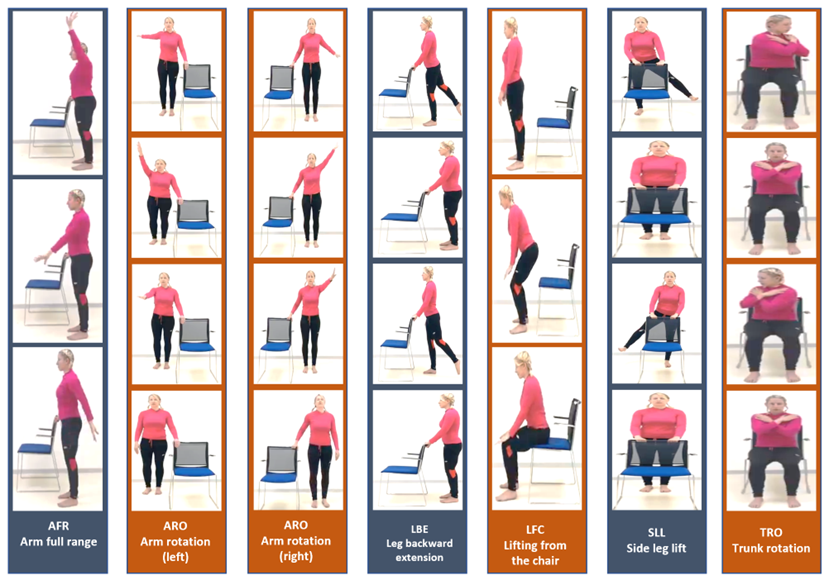

There are about 100 participants in the database, who each perform six exercises. Ten cycles comprise each exercise (e.g. rotating the right arm). Exercises are performed once with a right tilt and once with a left tilt (for example, once with a right foot rotation and once with a left foot rotation). A total of about 7500 motion cycle videos have been tagged and timed in the database. This study included healthy subjects (volunteers - stu-dents) with no disability identified during tests to control postural stability. The subjects group comprised of 4 men and 26 women with an average age of 21.1 (SD 1.2) years, body weight 64,8 (SD 9,4) kg and body height 170 (SD 9) cm. One single measurement of each subject was taken during the session. The study was performed in accordance with the Helsinki Declaration and the study protocol was approved by the local Ethical Com-mittee, by the Faculty of Biomedical Engineering, Czech Technical University in Prague. The entire database has been encoded as skeletons - a skeleton in every frame (see  figure bellow).

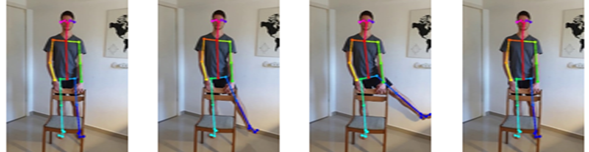

## Dataset content description (Numpy files)
The video recordings of students from the University of Prague and Ben Gurion University performing six exercises under the guidance of a physiotherapist were transformed into skeleton vectors using OpenPose software. The resulting data for each student's exercise was saved in a separate NPY file, which was composed of a four-dimensional Numpy array: X, Y, C, and frame number. The array contained the position of the skeleton vector in each frame, represented as rows in the file. Each skeleton vector was comprised of 25 key points, each described by X and Y coordinates indicating its position within the frame relative to the upper left corner, and a confidence value "C" between 0 (absolute uncertainty) and 1 (absolute certainty) indicating the accuracy of the key point location. As each student performed six distinct exercises, six NPY files were generated for each student via OpenPose, and these files served as the database for the subsequent analysis.

### Download zipped raw data

In [ ]:
!curl -L -o 'czech_raw_data.zip' 'https://drive.google.com/uc?id=1i0mFQjMGYlAaebpmxQt4teexeNaE3Mcy&confirm=t' #^^^^
!unzip -q "/content/czech_raw_data.zip" -d "/content/"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 40.7M  100 40.7M    0     0  87.5M      0 --:--:-- --:--:-- --:--:--  188M
replace /content/czech_raw_data/000023AFR.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/czech_raw_data/000025AFR.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/czech_raw_data/000025AFR.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/czech_raw_data/000025AFR.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/czech_raw_data/000025AFR.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/czech_raw_data/000025AFR.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/

# TSSIC - Tree Structure Skeleton Image Color



## Tree Structure Skeleton Image (TSSI)
Paper ```
Z. Yang, Y. Li, J. Yang, and J. Luo, ‘Action Recognition With Spatio–Temporal Visual Attention on Skeleton Image Sequences’, IEEE Trans Circuits Syst Video Technol, vol. 29, no. 8, pp. 2405–2415, 2019.
```
presents a method for recognizing human actions in video sequences using a combination of Spatio-temporal visual attention and skeleton image processing. In the article, the authors introduce the concept of converting the skeleton image sequences into Tree Structure Skeleton Image, which they refer to as "TSSI" images. TSSI images are a type of abstract image representation that captures a person's skeletal structure in a video sequence and can be used to analyze and recognize human actions.

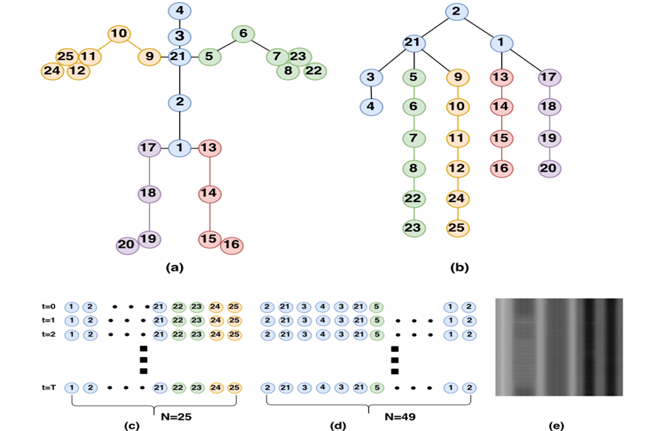

In [ ]:
#generates a TSSIC array by selecting and rearange skeleton keyframe from the input array.
def genTSSI(data_array):
  return data_array[:, [1,2,3,4,3,2,1,0,15,17,15,0,16,18,16,0,1,5,6,7,6,5,1,8,12,13,14,19,20,19,14,21,14,13,12,8,9,10,11,24,11,22,23,22,11,10,9,8,1]]

## TSSIC - TSSI as an RGB image
The researchers in the literature treat the movement as an object in motion, meaning a sequence of objects' positions, orientations, and sizes that change over time and space. 
Our approach provides a perspective on human movement as a RGB single image. In the first step, we treat TSSI as a color image (TSSIC), then generalize movement to a color image as an object. For example, If there are several objects in the picture (such as three cats in a typical picture), then in our model, there are three movements, and therefore there are three objects within the TSSIC image.
By applying this approach, an object can be small, meaning the object begins and ends simultaneously within the image. From our perspective, a small object indicates a fast motion as opposed to a large object, which implies a slower motion. As a result of adjusting two object sizes, we can sync them up.
We can locate the object in a specific place in the TSSIC image while identifying all other pixels as the background. The places where the object does not exist in the image indicate no movement or idle movement before and after the requested movement. Us-ing this concept, we can automatically determine when a movement starts and ends so that we can perform automatic editing to extract specific movements from long videos.  
Neural networks can extract unique attributes of objects in the latent space that ena-bles the network to differentiate between objects in the same way that is describing the movement as a super object allows us to extract the characteristics of the movement.
Generic Neural network implementations with TSSIC
We can use TSSIC images as inputs to all neural networks capable of analyzing and processing images. 


## Normalizing skeleton coordinates for the implementation as TSSIC pixels
For the results presented in this article, we used the Min-Max normalization method. We followed the following formulas:

If i is the row index in the TSSIC and j is the column index in the TSSIC and the $C_{ij} \geq threshold$ 
 (If the confidence level is low then the x, y  coordinate consider as noise).


$x_{max} = max(max(x_{ij}))$

$x_{min} = min(min(x_{ij}))$

$x_{L} = x_{max} - x_{min}$

$\hat{x}_{ij} = \frac{x_{ij}}{x_{L}}$

In the same way we calculate the normalized y component:

$\hat{y}_{ij} = \frac{y_{ij}}{y_{L}}$

The normalized key point $\widehat{kp}_{ij}$ define as:

$\widehat{kp}_{ij} = \left(\hat{x}_{ij}, \hat{y}_{ij}, c_{ij}\right)$

which used as our TSSIC pixel.

In [ ]:
# normalizes the values in the input array by scaling them to a range between 0 and 1.
def normalizeTSSI(tssiTensor):
  all_x = tssiTensor[:,:,0].copy()
  all_y = tssiTensor[:,:,1].copy()
  
  # find min_X max_X
  max_x = all_x.max()
  all_x[all_x == 0] = max_x+1
  min_x = all_x.min()
  all_x[all_x == max_x+1] = min_x
  
  # find min_Y max_Y
  max_y = all_y.max()
  all_y[all_y == 0] = max_y+1
  min_y = all_y.min()
  all_y[all_y == max_y+1] = min_y
  
  res = tssiTensor.copy()
  res[:,:,0] = (all_x-min_x)/(max_x-min_x)
  res[:,:,1] = (all_y-min_y)/(max_y-min_y)
  return res



## CNN-based automatic and manual video editing
In order to improve the accuracy of the initial training of movements, it was necessary to eliminate unnecessary frames at the beginning and end of each video. To achieve this, we manually edited the videos and marked the frame numbers for the start and end of each movement in a separate CSV file.
We also demonstrated that the TSSIC method is robust against the specific start and end location of the movement, as Convolutional Neural Networks (CNNs) have the ability to identify the movement regardless of its location or size in the video, much like how a CNN can identify a cat in an image despite its location or size within the image.
To accommodate both approaches, we developed a code that allows the user to work with either the entire video without editing, or with edited videos by specifying the start and end points using the CSV file, resulting in more accurate results.

In [ ]:
#extract specific rows from the input array based on time ranges provided in a list that describe the start and the end frame of the movment.
def removeFrames(tssiVec, timeRanges):
  if len(timeRanges) > 2:
    t1 = int(abs(timeRanges[0]))
    t2 = int(abs(timeRanges[1]))
    t3 = int(abs(timeRanges[2]))
    t4 = int(abs(timeRanges[3]))
    return tssiVec[np.r_[t1:t2,t3:t4]]
  else:
    t1 = int(abs(timeRanges[0]))
    t2 = int(abs(timeRanges[1]))
    return tssiVec[t1:t2]

#reads a CSV file that contain the frame ID that mark the start and the end of the exercise and extracts time ranges from it.
def extractTimeRanges(filePath):
  df = pd.read_csv(filePath)
  df.drop(columns=['Participant ID',' Exercise Code'], inplace=True)
  timeRanges = df.loc[0, :].values.tolist()
  return timeRanges


## Treatment of Low Confidence Level Key Points (Missing Key Points)
In some cases, the skeleton keypoint extraction software may fail to locate a keypoint with sufficient accuracy. This can be due to various reasons such as a person being photographed in profile, where one shoulder is visible while the other is hidden, or poor lighting conditions that affect image processing quality.

To address these missing keypoints, we implemented a method called **"complementing from the left"** in our algorithm. This method replaces missing keypoints with their closest neighbors on the left. This results in an unrealistic representation of the skeleton where body parts appear to be suspended in the air without any connections. For example, if the elbow keypoint is missing, the algorithm will only show the skeleton up to the shoulder, resulting in a floating palm detached from the shoulder.

Suppose there is a sequence of keypoints according to TSSIC description, for example ...0,1,5,6,7,6,5,1,8,12..., and keypoint 6 is missing (its confidence level is below a given threshold of 0.3). According to the left completion method, the sequence would look like ...0,1,5,5,7,7,5,1,8,12.... where 5 replaced the missing 6 and then 7 replaced the missing 6.

In [ ]:
# In case we have undetected skeleton point we will take the prevrios detected graph point (located left to the point in the vector) 
def addressZeroVal(OrigTssiVec):
  tssiVec = OrigTssiVec.copy()
  for i in range(tssiVec.shape[0]):
    for j in range(tssiVec.shape[1]):
      if tssiVec[i][j][0]*tssiVec[i][j][1]*tssiVec[i][j][2] == 0 :
        tssiVec[i][j] = tssiVec[i][j-1]
  return tssiVec


## Dataset Augmentation via resampling
The limited amount of video data in our database posed a challenge for training neural networks effectively. To address this, we applied dataset augmentation techniques to the videos.
The videos were sampled at 30 frames per second, with a 33-millisecond interval between consecutive frames. This short time frame made it difficult to capture significant differences in movement from one frame to the next. Each video in the database had a typical length of 100 seconds. To ensure that our method for measuring and labeling movements based on TSSIC was effective, we selected a sample of 49 frames (Approximately two seconds separate consecutive frames) , to obtain meaningful information between frames.
We employed two methods for modeling. The first method involved randomly selecting 49 frames out of the total number of frames, allowing for acceleration and deceleration within the exercise. The second method involved dividing the total number of frames into 49 equal segments and randomly selecting one frame from each segment. This method smoothed out fluctuations and internal accelerations within the exercise.

In [ ]:
#Dataset Augmentation
def genImageByRegion(arrNpy):
  arrShape = arrNpy.shape
  arrLen = arrShape[0]
  n_regions = arrLen / 49
  rows = []
  for i in range(49):
    r = np.random.randint(i*n_regions,(i+1)*n_regions)
    rows.append(r)
  return arrNpy[rows]

def genImageByRandom(arrNpy):
  arrShape = arrNpy.shape
  arrLen = arrShape[0]
  rows = np.random.randint(0, arrLen, 49)
  rows.sort()
  return arrNpy[rows]

def encodeTssi(fileName):
  movments = ["AFR", "ARO", "LBE", "LFC", "SLL", "TRO"]
  for i, move in enumerate(movments):
    if move in fileName:
      return i

def Sort_Tuple(tup):
  tup.sort(key = lambda x: x[1])
  return tup


### Skeleton and TSSIC Display and Animation functions

In [ ]:
#creates an animation of the input TSSIC array using Matplotlib.
def animateTSSI(tssiVec):
  fig, ax = plt.subplots()
  x, y = [],[]

  def animate(row):
    ax.clear()
    x.clear()
    y.clear()
    x.append(tssiVec[row][:,0])
    y.append(-tssiVec[row][:,1])
    ax.scatter(x, y)
    plt.xlim([0, 1])
    plt.ylim([-1, 0])
    ax.set_xlabel(f'frame: {row}')

  ani = animation.FuncAnimation(fig, animate, frames=range(tssiVec.shape[0]), interval=10)
  plt.show()

def displayTensor(tensor):
  transform = torchvision.transforms.ToPILImage()
  img = transform(tensor)
  scale = 6
  display(img.resize(( int(img.width * scale), int(img.height * scale))))

def animateTSSI(tssiVec):
  fig = plt.figure(figsize=(8,8))
  ax = plt.subplot() 
  plt.close()
  ax.set_xlim((0,1))            
  ax.set_ylim((1,0))
  line, = ax.plot([], [], 'b', lw=2)


  def drawframe(row):
    x = tssiVec[0,row,:].tolist()
    y = tssiVec[1,row,:].tolist()
    line.set_data(x, y)
    ax.set_title(f'frame: {row}')
    return line,

  anim = animation.FuncAnimation(fig, drawframe, frames=48, interval=100, blit=True)
  rc('animation', html='html5')
  return anim


def drawframe(tssiVec, movment_index, row ,generated=False):
  movments = ["AFR", "ARO", "LBE", "LFC", "SLL", "TRO"]
  fig = plt.figure(figsize=(8,8))
  ax = plt.subplot() 
  ax.set_xlim((0,1))            
  ax.set_ylim((1,0))
  line, = ax.plot([], [], 'b', lw=2)
  x = tssiVec[0,row,:].tolist()
  y = tssiVec[1,row,:].tolist()
  line.set_data(x, y)
  if generated:
    ax.set_title(f'Movment: \"{movments[movment_index]}\" , Frame: {row} , Synthetic Generated TSSI')
  else:
    ax.set_title(f'Movment: \"{movments[movment_index]}\" , Frame: {row}')

### Generation data step by step

generate our main dataset

In [ ]:
path = "/content"
folderName = "/czech_raw_data"
filePaths = []

for dirName, _, fileNames in os.walk(path+folderName):
    for fileName in fileNames:
        filePaths.append((dirName, fileName))

#### Load Numpy Files

Load numpy files to numpy array:

In [ ]:
#loads a NumPy array from a file
loadNumpyArray = []

for dirName, fileName in filePaths:
  if ".npy" not in fileName:
    continue
  x = np.load(os.path.join(dirName, fileName))
  loadNumpyArray.append((dirName, fileName, x))

#### Extract Time Range

If there are csv files of time range of the main movment, er can remove static frames:

In [ ]:
afterFrameRemove = []

for dirName, npyFileName, numpyArray in loadNumpyArray:
  csvFilePath = npyFileName.replace(".npy",".csv")
  x = numpyArray
  try:
    timeRange = extractTimeRanges(os.path.join(dirName, csvFilePath))
    x = removeFrames(numpyArray, timeRange)
  except:
    pass
  afterFrameRemove.append((npyFileName, x))

#### Generate TSSIC

Generate from the numpy array a TSSIC image while each row is 49 points:

In [ ]:
tssiImages = []

for fileName, numpyArray in afterFrameRemove:
  x = genTSSI(numpyArray)
  tssiImages.append((fileName, x))

#### Normalization

Normalize the TSSIC image values to [0,1]:

In [ ]:
tssiNormal = []

for fileName, tssiImage in tssiImages:
  x = normalizeTSSI(tssiImage)
  tssiNormal.append((fileName, x))

#### Address key frames with Low confidance Values

Handle zero values in our TSSIC image by copied the nearest ledt pixel:

In [ ]:
tssiNormalNoZero = []

for fileName, tssiImage in tssiNormal:
  x = addressZeroVal(tssiImage)
  tssiNormalNoZero.append((fileName, x))

#### Data Augmentation

Perform data augmentation using two methods:

1.   choosing 49 rows randomly.
2.   split the hight of the image to 49 regions and rendomly choose a row in each region. 



In [ ]:
tssiAug = []

for fileName, tssiImage in tssiNormalNoZero:
  for i in range(6):
    fileName = fileName.replace(".npy","")
    squareTssiByRegion = genImageByRegion(tssiImage)
    tssiAug.append((f"{fileName}_{i}_region", squareTssiByRegion))
    squareTssiByRandom = genImageByRandom(tssiImage)
    tssiAug.append((f"{fileName}_{i}_random", squareTssiByRandom))

#### Sort By Movment

Sort our fianl list by movment label:

In [ ]:
tssiImagesWithLabels = []

for fileName, tssiImage in tssiAug:
  movmIndex = encodeTssi(fileName)
  tssiImagesWithLabels.append((tssiImage, movmIndex))

tssiImagesWithLabels_sort = Sort_Tuple(tssiImagesWithLabels)

#### Label Encoding

Encoding each movment index to OneHot presentation:

In [ ]:
tssiWithOneHotLabels = []

for tssiImage, label in tssiImagesWithLabels_sort:
  oneHotLabel = nnF.one_hot(torch.tensor(label), num_classes=6)
  tssiWithOneHotLabels.append((tssiImage, oneHotLabel))

#### Save Dataset

Saving the data in x_data.npy  (TSSIC images) and y_data.npy (Movments names - Labels) files:

In [ ]:
x_data = []
y_data = []

for x, y in tssiWithOneHotLabels:
  x_data.append(x)
  y_data.append(y)

# Convert the x_data and y_data lists to numpy arrays
x_data = np.array(x_data)
y_data = np.array(y_data)

np.save(f"tssi_x_data", x_data)
np.save(f"tssi_y_data", y_data)

<ipython-input-18-8d64f92386ee>:10: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  y_data = np.array(y_data)
<ipython-input-18-8d64f92386ee>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_data = np.array(y_data)


### TSSIC Data which prepared in advance
In the previous cells, we demonstrated how to create the dataset for the group of exercises performed by the students from the University of Prague. Our preprocessed involves merging all TSSIC images into a single large tensor stored in the x_data array. This tensor has four dimensions: x,y,c, and an index number corresponding to each exercise performed by all students. We used one-hot encoding in the y_data array to label each exercise (names of movements).
Preparing, normalizing, and encoding the dataset is time-consuming in a Google Colab notebook, so it was done on a local computer using the same code. We saved the resulting data in a shared folder. We are loading them in the next cell to use them as our dataset in this notebook.

Download the preprocessed data:

In [ ]:
!curl -L -o 'czech_tssi_x_data.npy' 'https://drive.google.com/uc?id=1g0ZINMjwLsfJP53XRkNV2oWYDxW3L7NF&confirm=t' #^^^^
!curl -L -o 'czech_tssi_y_data.npy' 'https://drive.google.com/uc?id=1fdH0ZYuh7vt6MgHTDldNVzf7tfaLAeOE&confirm=t'
!curl -L -o 'bgu_tssi_x_data.npy' 'https://drive.google.com/uc?id=1BiMwCG0R4XXzAwUi6EIA7-gO0SYdq3lI&confirm=t'
!curl -L -o 'bgu_tssi_y_data.npy' 'https://drive.google.com/uc?id=1q_JqS_dAGTfC6C3gXoN2F5vv-27vKV3x&confirm=t'
!curl -L -o 'expert_tssi_x_data.npy' 'https://drive.google.com/uc?id=1FFucmkSE6L3Jspc_ubIQjAKTD5haMVIz&confirm=t'
!curl -L -o 'expert_tssi_y_data.npy' 'https://drive.google.com/uc?id=1ktRPIcGWxrh11-QE_uIOXruS0vDbHZIz&confirm=t'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  110M  100  110M    0     0  93.5M      0  0:00:01  0:00:01 --:--:--  300M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  694k  100  694k    0     0  1180k      0 --:--:-- --:--:-- --:--:-- 1180k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0
100 71.2M  100 71.2M    0     0  17.4M      0  0:00:04  0:00:04 --:--:-- 17.4M
  % Total    % Received % Xferd  Average Speed   Tim

## Creating the Extended Database using Normalization and Augmentation
We utilized the EfficientNet-B7 network to classify six pre-defined movements from a database containing 100 students, each performing six movements. With the help of OpenPose, the skeleton vectors were extracted from the video's frames into NumPy arrays (The skeleton key points vector extracted from a video frame is a line in the array) and underwent a centering operation to place the skeleton in the center of the frame. The x and y coordinates were normalized to values between 0 and 1, while the level of confidence c remained between 0 and 1. Due to the low confidence level values for some key points, we could not rely on the position evaluation values provided by OpenPose. Instead, we used the "complementing from the left" algorithm. For instance, if the elbow keypoint were missing, the algorithm would only display the skeleton up to the shoulder, resulting in a floating palm in the air separate from the body.
We selected 49 random lines from each normalized Numpy file for augmentation. Those 49 lines are equivalent to 49 frames with an interval between frames of approximately two seconds. We used them to create a TSSIC tensor, an RGB color image where the Red channel represents x values, the Blue channel represents y values, and the Green channel represents the confidence level c. We repeated this operation  2004 times to generate a total of 2004 tagged TSSIC images. We used 1603 images for training (80%) and the remaining 401 (20%) for evaluation.

In [ ]:
#Load TSSIC dataset (numpy files)
filePath = '/content'

## x_data
fileName = 'czech_tssi_x_data.npy'   #^^^^
npy_x_data = np.load(filePath+'/'+fileName, allow_pickle=True)
npy_x_data = npy_x_data.transpose(0, 3, 1, 2)

# y_data
fileName = 'czech_tssi_y_data.npy'
npy_y_data = np.load(filePath+'/'+fileName, allow_pickle=True)
npy_y_data = np.array([x.numpy() for x in npy_y_data.tolist()]) #^^^^

# Convert the input data to PyTorch tensors
x_data = torch.from_numpy(npy_x_data).float()
y_data = torch.from_numpy(npy_y_data).float()

In [ ]:
# Shuffle and split the data into a training set and a test set
dataset = data.TensorDataset(x_data, y_data)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = data.random_split(dataset, [train_size, test_size])

# Define the data loaders for the training and test sets
train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)

Here are some examples from the Extended Database using normalization and augmentation. The following table shows TSSIC and one of its single skeletons. The examples provided here are taken from the videos of the physiotherapist. The expert is our source of reference when it comes to performing a correct exercise.

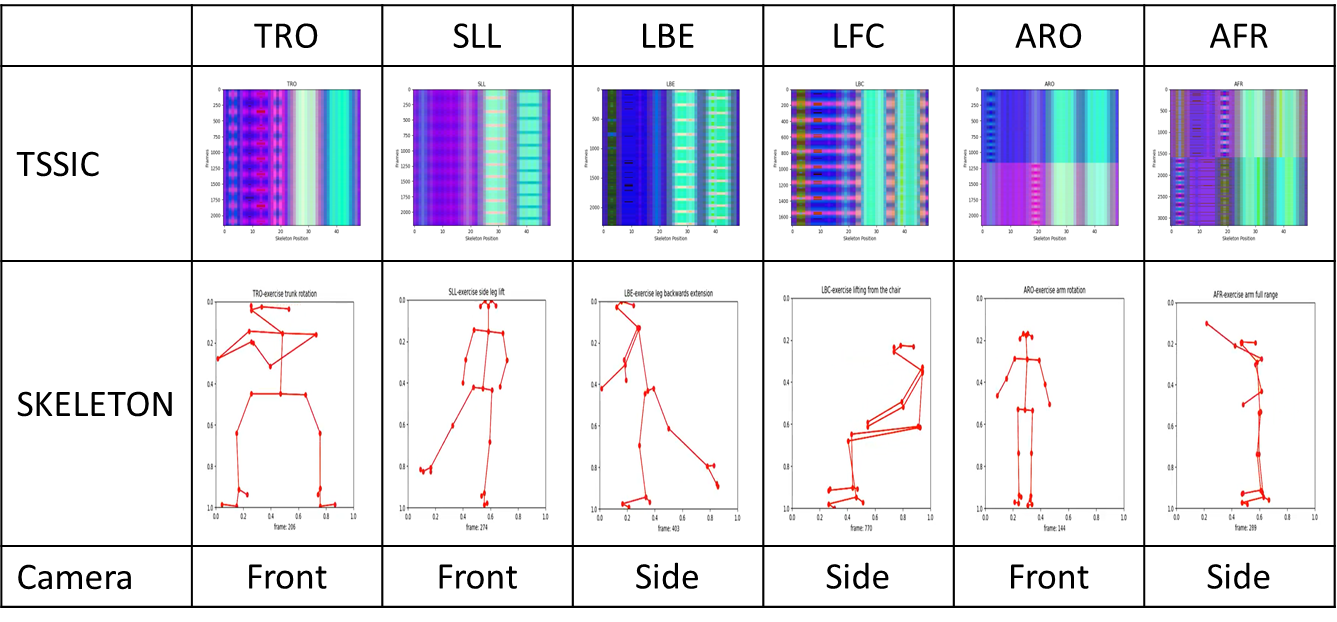

# Model Selection: CNN Classification with Google EfficientNet

We using for the CNN model the  EfficientNet-B7 classifier architecture. “EfficientNet-B7 achieves state-of-the-art 84.4% top-1 / 97.1% top-5 accuracy on ImageNet, while being 8.4x smaller and 6.1x faster on inference than the best existing ConvNet.”

The article "EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks" by M. Tan and Q. Le presents a new method for scaling Convolutional Neural Networks (CNNs) called EfficientNet. The authors propose a comprehensive approach to scaling CNNs that considers both depth and width of the network, as well as the resolution of the input image. The method is based on the observation that increasing the depth and width of a network leads to better performance, but also increases computational cost and requires more data. To balance these trade-offs, the authors propose a compound scaling method that adjusts the depth, width, and resolution of the network together. The method is evaluated on a range of image classification tasks and outperforms existing models in terms of accuracy, computational cost, and number of parameters. The authors also demonstrate that the EfficientNet method can be applied to other tasks beyond image classification, such as object detection and semantic segmentation. The results of this work suggest that the EfficientNet method is a promising approach for scaling CNNs and improving their performance in a variety of tasks.

### EfficientNet Transfer Learning
To improve the learning and prediction performance of our model with limited data, we employed several methods. One method was data augmentation, as previously discussed. Another method was taking advantage of the pre-trained EfficientNet network for image classification by performing Transfer Learning.
In our approach, we froze the training of the first three layers of the network, as we believed these layers were responsible for extracting and learning the background information of the objects, which is common across different object types. This allowed us to focus the training on the last layers, which were tasked with learning the specific features of our motion object. By doing this, we aimed to achieve improved performance while minimizing the risk of overfitting to the limited data available.

We set the EfficientNet to num_classes=6 because we have 6 movments "AFR", "ARO", "LBE", "LFC", "SLL", "TRO"


In [ ]:
# Define the EfficientNet model
EfficientNet_model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=6).to(device)

# Lock the first 3 layers of the model
for param in EfficientNet_model._blocks[:3]:
    for p in param.parameters():
        p.requires_grad = False
for param in EfficientNet_model._blocks[3:]:
    for p in param.parameters():
        p.requires_grad = True

Loaded pretrained weights for efficientnet-b0


In [ ]:
# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(EfficientNet_model.parameters())


### Train and Evaluate the EfficientNet model on TSSIC images

**Note**: Continuation of Training with Each Cell Execution

It's important to note that every time this cell is executed, the model will continue to train from the last point of interruption. If you wish to start the training from the beginning, you must reconfigure and reload the model, which can be done by referring to the two cells above.

In [ ]:
# Define lists to store the training loss, accuracy, and test loss, accuracy
train_losses = []
train_accs = []
test_losses = []
test_accs = []

epochs = 20

# Train the model
for epoch in range(epochs):
    # Training
    EfficientNet_model.train()
    train_loss = 0
    train_acc = 0
    for x, y in train_loader:
        # Forward pass
        output = EfficientNet_model(x.to(device))
        loss = criterion(output, y.to(device))
        train_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute the accuracy
        y_pred = torch.sigmoid(output)
        y_pred = (y_pred > 0.5).float()
        train_acc += (y_pred.cpu() == y).float().mean()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluation
    EfficientNet_model.eval()
    test_loss = 0
    test_acc = 0
    with torch.no_grad():
        for x, y in test_loader:
            # Forward pass
            output = EfficientNet_model(x.to(device))
            loss = criterion(output, y.to(device))
            test_loss += loss.item()

            # Compute the accuracy
            y_pred = torch.sigmoid(output)
            y_pred = (y_pred > 0.5).float()
            test_acc += (y_pred.cpu() == y).float().mean()

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f'Epoch {epoch+1}: Train loss = {train_loss:.4f}, Train accuracy = {train_acc:.4f}, Test loss = {test_loss:.4f}, Test accuracy = {test_acc:.4f}')

Epoch 1: Train loss = 0.1599, Train accuracy = 0.9486, Test loss = 1.2398, Test accuracy = 0.2238
Epoch 2: Train loss = 0.0257, Train accuracy = 0.9951, Test loss = 1.1375, Test accuracy = 0.2906
Epoch 3: Train loss = 0.0179, Train accuracy = 0.9953, Test loss = 0.7019, Test accuracy = 0.6788
Epoch 4: Train loss = 0.0219, Train accuracy = 0.9952, Test loss = 0.3975, Test accuracy = 0.8374
Epoch 5: Train loss = 0.0175, Train accuracy = 0.9949, Test loss = 0.1649, Test accuracy = 0.9389
Epoch 6: Train loss = 0.0122, Train accuracy = 0.9974, Test loss = 0.0296, Test accuracy = 0.9900
Epoch 7: Train loss = 0.0167, Train accuracy = 0.9950, Test loss = 0.0170, Test accuracy = 0.9964
Epoch 8: Train loss = 0.0159, Train accuracy = 0.9974, Test loss = 0.0987, Test accuracy = 0.9610
Epoch 9: Train loss = 0.0358, Train accuracy = 0.9905, Test loss = 0.0001, Test accuracy = 1.0000
Epoch 10: Train loss = 0.0174, Train accuracy = 0.9960, Test loss = 0.0008, Test accuracy = 1.0000
Epoch 11: Train los

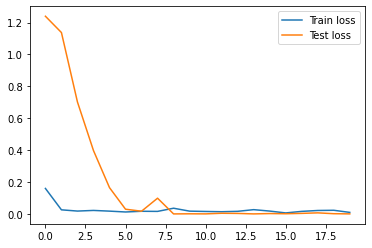

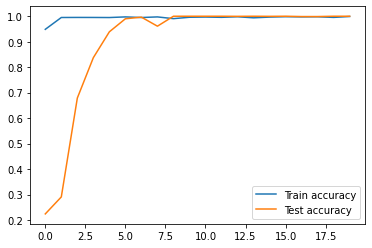

In [ ]:
# Plot the loss and accuracy for the training and test sets
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.show()

plt.plot(train_accs, label='Train accuracy')
plt.plot(test_accs, label='Test accuracy')
plt.legend()
plt.show()

### Confusion matrix
We utilized the pre-trained EfficientNet-B7 network for image classification by per-forming Transfer Learning. We set the network to have six outputs corresponding to the six movements, with an evaluation set that contains: 70 images for AFR, 66 images for ARO, 74 images for LBE, 70 images for LFC, 67 images for SLL, and 54 images for TRO. 
The EfficientNet-B7 network gave us a probability six-dimension vector for each movement, summarized into one (100%). To perform the movement detection, we first converted a video of a movement into a TSSIC image, which was then input into the trained EfficientNet-B7 network. We determined the predicted movement label by select-ing the output with the highest probability. The classification performance was meas-ured using an evaluation set of 401 samples. The results were presented in a confusion matrix, as shown bellow.


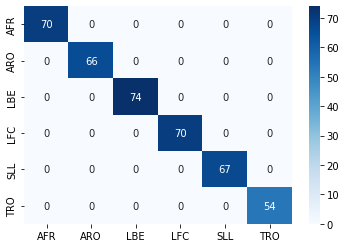

In [ ]:
# Make predictions on the test set
EfficientNet_model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for x, y in test_loader:
        output = EfficientNet_model(x.to(device))
        y_pred_batch = torch.sigmoid(output)
        y_pred_batch = (y_pred_batch.cpu() > 0.5).float()
        y_true.extend(y.tolist())
        y_pred.extend(y_pred_batch.tolist())

# Convert the one-hot encoded labels back to their original categorical format
y_true = np.argmax(y_true, axis=1)
y_pred = np.argmax(y_pred, axis=1)
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, xticklabels = movmentsName, yticklabels = movmentsName)

100% Accuracy

### Inference on new type of data (BGU TSSIC's )
The difference in resolution and orientation of the photographs is a significant con-cern as it can impact the performance of the deep learning model. The four different ori-entations observed - head touching the upper edge of the monitor, a skeleton lying on the right side, upside down, and a skeleton lying on the left - could potentially affect the ac-curacy of the model's predictions (see TRO exercise as example in Figure 3). To mitigate this issue, we had to perform data pre-processing by rotating the skeletons to a standard orientation (0 degree).

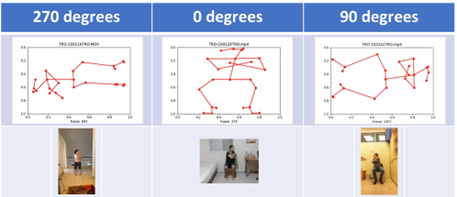

In [ ]:
# x_data #^^^^
fileName = filePath+'/'+'bgu_tssi_x_data.npy'
bgu_x_data  = np.load(fileName, allow_pickle=True)
bgu_x_data = bgu_x_data.transpose(0, 3, 1, 2)

# y_data
fileName = filePath+'/'+'bgu_tssi_y_data.npy'
bgu_y_data = np.load(fileName,allow_pickle=True)
bgu_y_data = np.array([x.numpy() for x in bgu_y_data.tolist()]) #^^^^

# Convert the input data to PyTorch tensors
bgu_x_data = torch.from_numpy(bgu_x_data).float()
bgu_y_data = torch.from_numpy(bgu_y_data).float()

# Create dataloader
bgu_dataset = data.TensorDataset(bgu_x_data, bgu_y_data)
bgu_test_loader = data.DataLoader(bgu_dataset, batch_size=32, shuffle=False)

We conducted a classification on a noisy data set consisting of exercises performed by students from Ben Gurion University in a home environment. The BGU students rec-orded these exercises under challenging conditions with varying cameras, shooting dis-tances, camera movement, and lighting. We did not edit the BGU student videos; there-fore, each exercise starts and ends at different times.
We evaluated the results by presenting them in a confusion matrix, which summa-rizes the network's predictions for each exercise (see Figure 11). The network output is a probability vector for each of the six exercises, and the chosen exercise has the highest probability. The diagonal of the matrix shows how many times the network correctly predicted the exercise.
Despite the difficult conditions and although each exercise begins and ends in a dif-ferent frame, the results show that the network was able to classify the exercises success-fully since the diagonal of the matrix is dominant. When using the super object method, we treat the movement as an object, allowing the network to classify movements effec-tively even when shooting conditions change.

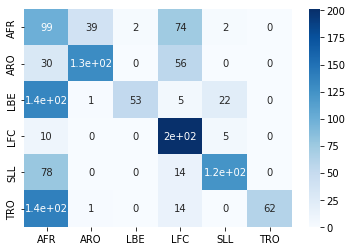

In [ ]:
# Make predictions on the test set
EfficientNet_model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for x, y in bgu_test_loader:
        output = EfficientNet_model(x.to(device))
        y_pred_batch = torch.sigmoid(output)
        y_pred_batch = (y_pred_batch.cpu() > 0.5).float()
        y_true.extend(y.tolist())
        y_pred.extend(y_pred_batch.tolist())

# Convert the one-hot encoded labels back to their original categorical format
y_true = np.argmax(y_true, axis=1)
y_pred = np.argmax(y_pred, axis=1)
# Compute the confusion matrix
bgu_cm = confusion_matrix(y_true, y_pred)

sns.heatmap(bgu_cm, annot=True, cmap=plt.cm.Blues, xticklabels = movmentsName, yticklabels = movmentsName)

While it is possible to continue training and improving the network to achieve better results, that is beyond the scope of this article. The goal is to demonstrate the effective-ness of the super object method in referring to movement.

# VEA Model - Generate new fake movments - Genrate new TSSIC images
Our goal is to create synthetic motions similar to the six movements found in our TSSIC picture database, which contains 2004 photos labeled with one of the six movements. 

Variation Auto Encoder (VAE) architecture was presented by Kingma and Welling in the paper ‘Auto-Encoding Variational Bayes’. The authors describe VAE  as a generative model trained using variational principles, which presents an unsupervised learning approach. There are two main components to the VAE architecture: an encoder and a decoder. It is possible to illustrate the architecture using diagrams, as shown in the Figure bellow: The encoder converts input data into a latent rep-resentation, and the decoder converts that latent representation back into the original data space.

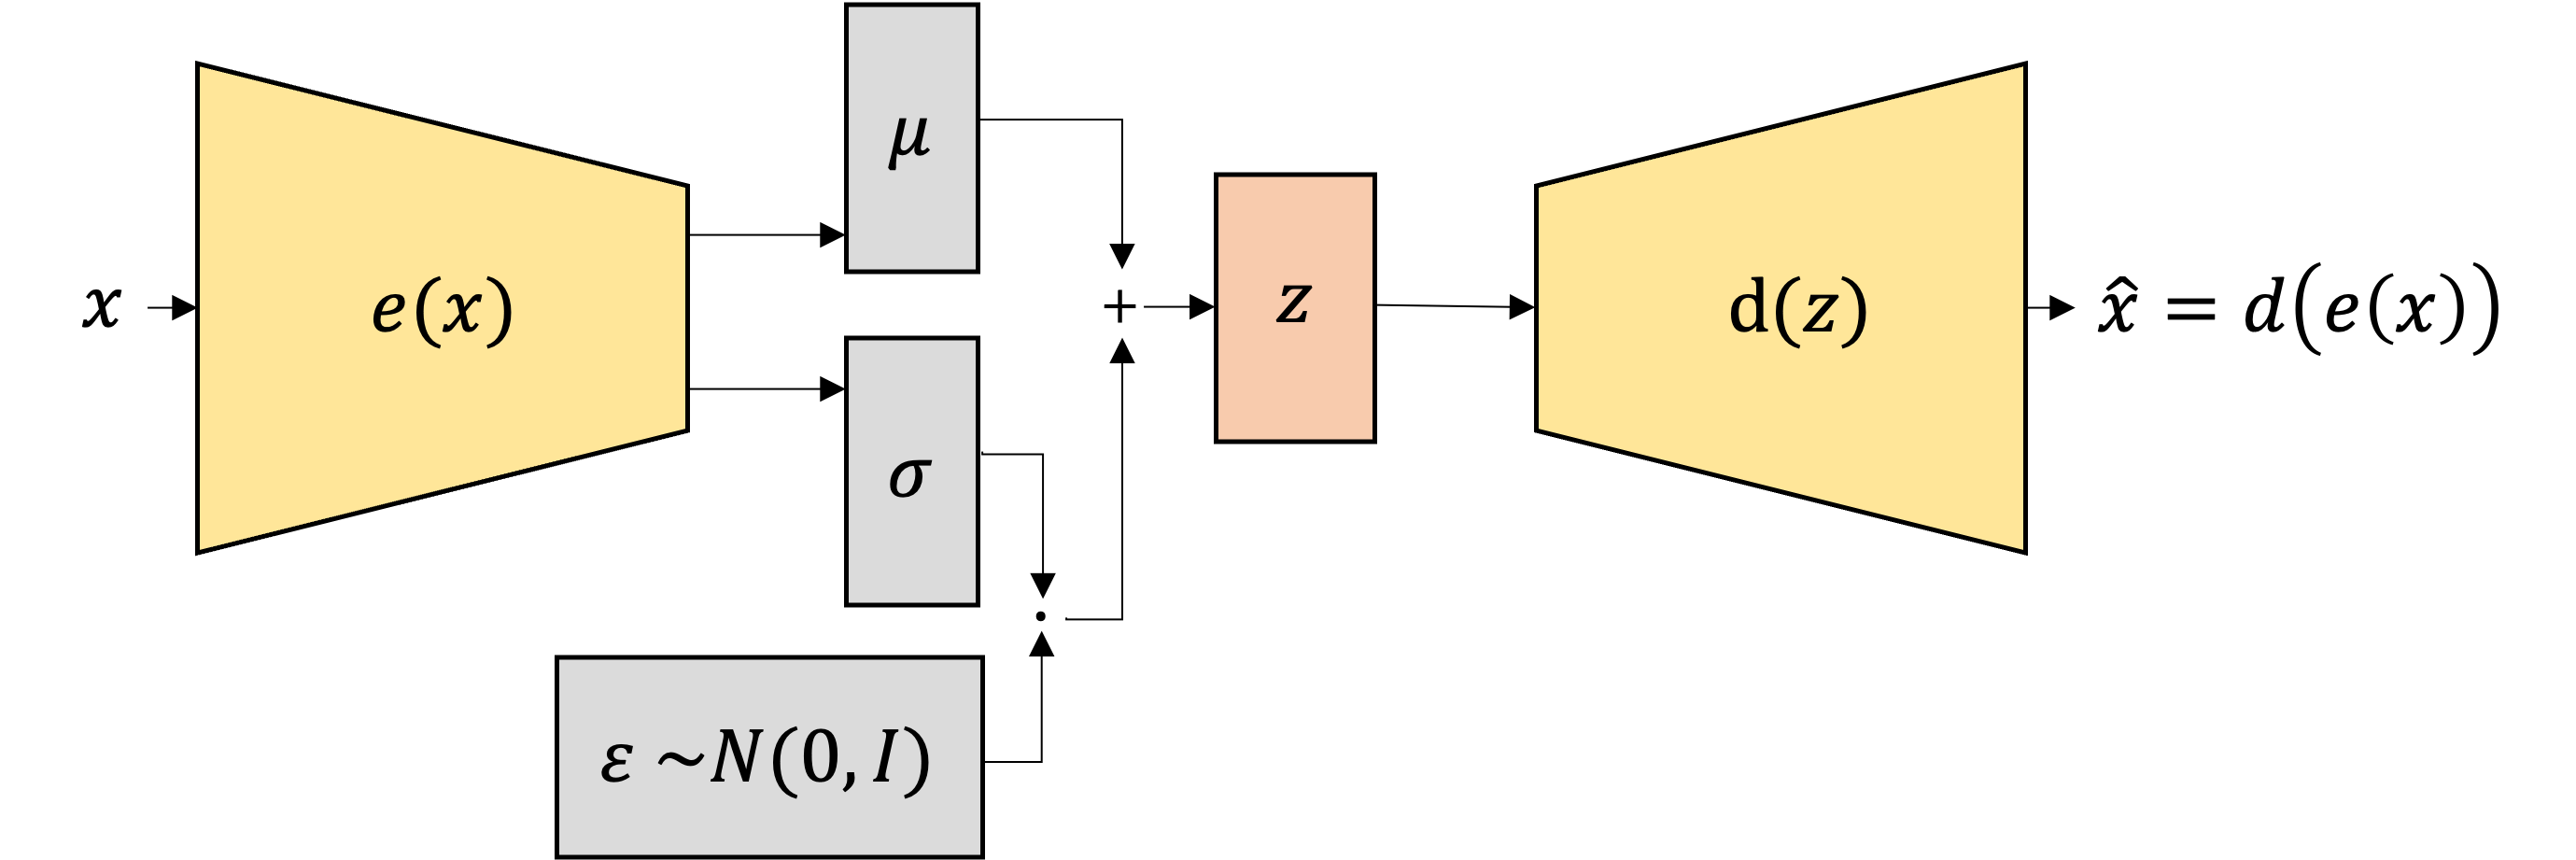

### Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, latent):
        super(Encoder, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, num_hiddens, kernel_size=(3,3), stride=(2,2), padding = 1),
            nn.BatchNorm2d(num_hiddens),
            nn.ReLU()
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(num_hiddens, num_hiddens * 2, kernel_size=(3,3), stride=(2,2), padding = 1),
            nn.BatchNorm2d(num_hiddens * 2),
            nn.ReLU()
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(num_hiddens * 2, num_hiddens * 4, kernel_size=(3,3), stride=(2,2), padding = 1),
            nn.BatchNorm2d(num_hiddens * 4),
            nn.ReLU()
        )
        
        self.block4 = nn.Sequential(
            nn.Conv2d(num_hiddens * 4, num_hiddens * 8, kernel_size=(3,3), stride=(2,2), padding = 1),
            nn.BatchNorm2d(num_hiddens * 8),
            nn.ReLU()
        )

        # (3, 49, 49) -> (256,  4,  4)
        self.fc_mu = nn.Linear(256*4*4 ,latent)     # Insert the input size
        self.fc_logvar = nn.Linear(256*4*4 ,latent) # Insert the input size

    def forward(self, inputs):
        
        x = self.block1(inputs)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        x = torch.flatten(x, start_dim=1)
        
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar 

In [ ]:
#print(summary(Encoder(3, 32, 3), (1, 3, 49, 49)))

### Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, latent):
        super(Decoder, self).__init__()
        self.fc_dec = nn.Linear(latent, 256*4*4) # Insert the output size

        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels, num_hiddens // 2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_hiddens//2),
            nn.LeakyReLU()
        )
        
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(num_hiddens // 2, num_hiddens // 4, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_hiddens//4),
            nn.LeakyReLU()
        )

        self.block3 = nn.Sequential(
            nn.ConvTranspose2d(num_hiddens // 4, num_hiddens // 8, kernel_size=3, stride=2, padding = 1),
            nn.BatchNorm2d(num_hiddens//8),
            nn.LeakyReLU()
        )
        
        self.block4 = nn.Sequential(
            nn.ConvTranspose2d(num_hiddens // 8, num_hiddens // 8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_hiddens//8),
            nn.LeakyReLU()
        )

        self.block5 = nn.Sequential(
            nn.Conv2d(num_hiddens//8, out_channels=3,kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.Sigmoid(),
        )


    def forward(self, inputs):
        x = self.fc_dec(inputs)
        x = x.view(-1,256,4,4)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x_rec = self.block5(x)
        return x_rec

In [ ]:
#print(summary(Decoder(256, 256, 3), (1, 3)))

In [ ]:
class VAE(nn.Module):
    def __init__(self, enc_in_chnl, enc_num_hidden, dec_in_chnl, dec_num_hidden, latent):
        super(VAE, self).__init__()
        self.encode = Encoder(in_channels=enc_in_chnl, num_hiddens=enc_num_hidden, latent = latent)
        self.decode = Decoder(in_channels=dec_in_chnl, num_hiddens=dec_num_hidden, latent = latent)

    # Reparametrization Trick
    def reparametrize(self, mu, logvar):
      if self.training:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)     
        return eps.mul(std).add_(mu)
      else:
        return mu

    # Initialize Weights
    def weight_init(self, mean, std):
        for m in self._modules:
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                m.weight.data.normal_(mean, std)
                m.bias.data.zero_()

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        x_rec = self.decode(z)
        return x_rec , mu, logvar

### VEA loss function

This loss function should merge same keypoint to have the same valus (x,y,c)

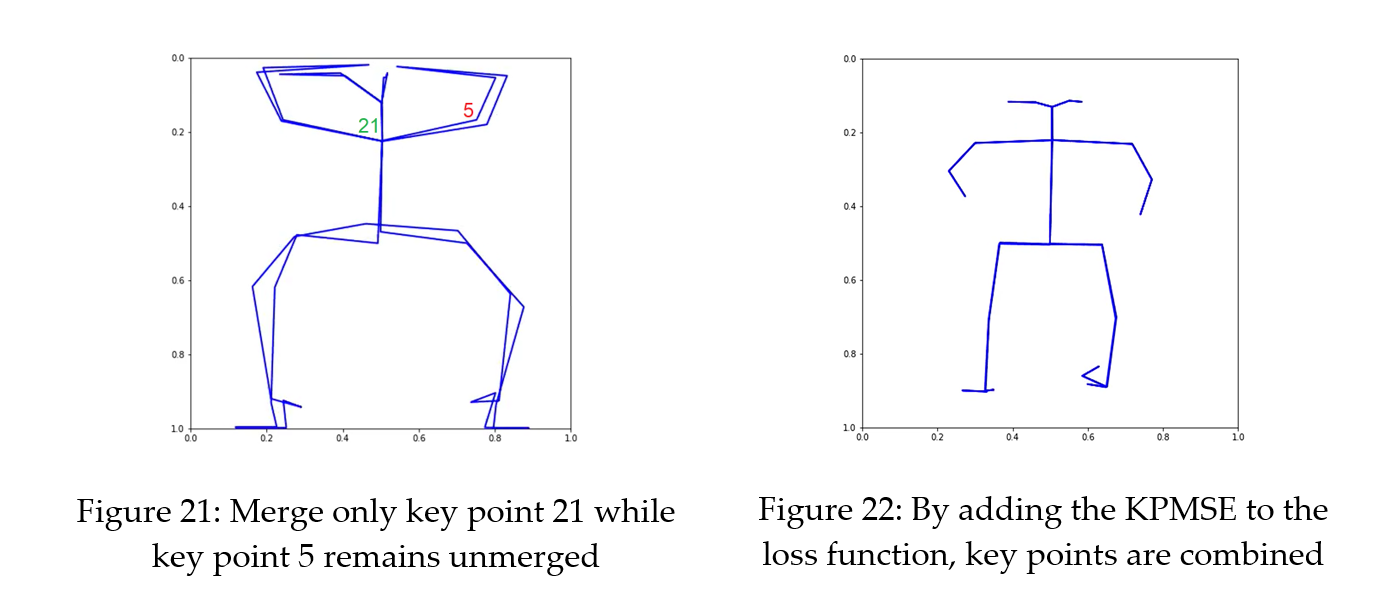


$$KPMSE = \sum_{r=1}^{row} \sum_{i=1}^{col} \sum_{j=1}^{ide} \left(x_{ri} - x_{rj}\right)^2 + \left(y_{ri} - y_{rj}\right)^2 + \left(c_{ri} - c_{rj}\right)^2$$

where: <br>
row- Number of rows in the TSSIC image <br>
col-Number of columns in the TSSIC image <br>
ide-Number of identical key points in TSSIC <br>

It is decided to add the KPMSE to the original VAE loss function while using alpha and beta as weights to achieve a balance between the components of the loss function. Our new loss function, which helps to merge identical key points, is described in the formula below:
$$Loss = MSE + \beta DKL + \alpha KPMSE \quad \text{where} \quad 0 \le \alpha, \beta \le 1$$

In [ ]:
class kpse_loss(torch.nn.Module):
  def __init__(self):
    super(kpse_loss, self).__init__()
  
  def forward(self, y):
    d = 0
    
    def normFunction(p0,p1):
      return torch.norm((y[:, :, :, p0] - y[:, :, :, p1]),'fro')

    # Point 1
    d += normFunction( 0, 6)
    d += normFunction( 6,16)
    d += normFunction(16,22)
    d += normFunction(22,48)
    d += normFunction(48, 0)
    
    # Points 2,3
    d += normFunction( 1, 5)
    d += normFunction( 2, 4)

    # Point 0 
    d += normFunction( 7,11)
    d += normFunction(11,15)
    d += normFunction(15, 7)

    # Points 5,6,15,16
    d += normFunction( 8,10)
    d += normFunction(12,14)
    d += normFunction(17,21)
    d += normFunction(18,20)

    # Point 8
    d += normFunction(23,35)
    d += normFunction(35,47)
    d += normFunction(47,23)

    # Points 12,13
    d += normFunction(24,34)
    d += normFunction(25,33)

    # Point 14
    d += normFunction(26,30)
    d += normFunction(30,32)
    d += normFunction(32,26)

    # Points 9,10,19
    d += normFunction(27,29)
    d += normFunction(36,46)
    d += normFunction(37,45)

    # Point 11
    d += normFunction(38,40)
    d += normFunction(40,44)
    d += normFunction(44,38)

    # Point 22
    d += normFunction(41,43)

    return d/29


In [ ]:
KPSE_Loss = kpse_loss().to(device)

def VEA_loss(y_hat, y, mu, logvar, batch_idx, beta = 0.1):
    alpha = 0 # merge key points weights loss function ('0' - not using it) 
    MSE = nnF.mse_loss(y_hat, y, reduction='sum')
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
    KLD_factor = 100*KLD
    KPSE = KPSE_Loss(y_hat)

    loss = torch.log(1+MSE)*(1-beta) + beta*torch.log(1+KLD_factor) + alpha*KPSE
    
    #if batch_idx % 100 == 0:
    #  print(f'LOSS INFO at batch {batch_idx} - loss: {loss}, MSE: {MSE}, KLD: {KLD}, KPSE: {KPSE}  ;  torch.log(1+MSE): {torch.log(1+MSE)}, torch.log(1+KLD_factor): {torch.log(1+KLD_factor)}, alpha*KPSE: {alpha*KPSE}')
    
    return loss

In [ ]:
learning_rate = 1e-3
batch_size = 8
num_epochs = 60

#VAE Class inputs: 
enc_in_chnl = 3
enc_num_hidden = 32
dec_in_chnl = 256
dec_num_hidden = 256

### Train

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

In [ ]:
def VEA_train(model, train_loader, test_loader, optimizer, batch_size, num_epochs=10):
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        train_loss = 0
        test_loss = 0
        if epoch >= 0: 
          model.train()

          for batch_idx, batch in enumerate(train_loader):            
            imgs, _ = batch
            if torch.cuda.is_available():
              imgs = imgs.cuda()

            # Compute the loss and update the model parameters.
            # ===================forward=====================
            recon_imgs, mu, log_var = model(imgs)
            loss = VEA_loss(recon_imgs, imgs, mu, log_var, batch_idx)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
          # ===================log========================
          train_loss /= len(train_loader)
          print(f'====> Epoch: {epoch} Average loss: {train_loss}')

        # Test set
        with torch.no_grad():
            model.eval()
            for batch_idx, batch in enumerate(test_loader):
                recon_imgs, _ = batch
                if torch.cuda.is_available():
                    imgs = imgs.cuda()

                # ===================forward=====================
                recon_imgs, mu, log_var = model(imgs)
                loss = VEA_loss(recon_imgs, imgs, mu, log_var, batch_idx)
                test_loss += loss.item()

            # =====================log=======================
            test_loss /= len(test_loader)
            print(f'====> Test set loss: {test_loss}')

        # Record the loss for each epoch.
        train_losses.append(train_loss)
        test_losses.append(test_loss)

    return train_losses, test_losses

In [ ]:
latent = 16

if torch.cuda.is_available():
    VEA_model = VAE(enc_in_chnl, enc_num_hidden, dec_in_chnl, dec_num_hidden, latent).cuda()
    VEA_model.weight_init(mean=0, std=0.02)
else:
    VEA_model = VAE(enc_in_chnl, enc_num_hidden, dec_in_chnl, dec_num_hidden, latent)
    VEA_model.weight_init(mean=0, std=0.02)

optimizer = torch.optim.Adam(VEA_model.parameters(), lr=learning_rate)

In [ ]:
#Train VAE
train_losses, test_losses = VEA_train(VEA_model, train_loader, test_loader, optimizer, batch_size, num_epochs)

====> Epoch: 0 Average loss: 7.2039248741681305
====> Test set loss: 5.888981819152832
====> Epoch: 1 Average loss: 6.731486647876341
====> Test set loss: 5.740230560302734
====> Epoch: 2 Average loss: 6.631447668692366
====> Test set loss: 5.601985454559326
====> Epoch: 3 Average loss: 6.552929709799847
====> Test set loss: 5.145966053009033
====> Epoch: 4 Average loss: 6.514246081831443
====> Test set loss: 5.395751476287842
====> Epoch: 5 Average loss: 6.474550130948498
====> Test set loss: 5.713720798492432
====> Epoch: 6 Average loss: 6.439071159457686
====> Test set loss: 5.26174259185791
====> Epoch: 7 Average loss: 6.43137387138101
====> Test set loss: 5.258571624755859
====> Epoch: 8 Average loss: 6.37959491910033
====> Test set loss: 5.4303717613220215
====> Epoch: 9 Average loss: 6.36690089240003
====> Test set loss: 5.1283159255981445
====> Epoch: 10 Average loss: 6.355209661360404
====> Test set loss: 5.559724807739258
====> Epoch: 11 Average loss: 6.334349575327404
====> 

The VAE training loss progress  is presented bellow

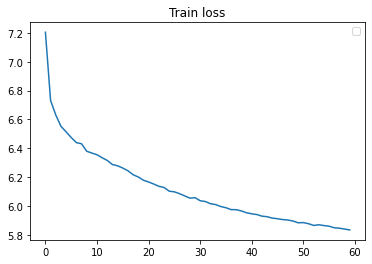

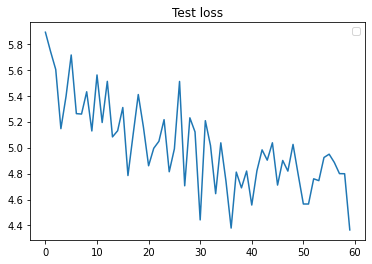

In [ ]:
# Plot the train and validation losses.
plt.plot(train_losses)
plt.title('Train loss')
plt.legend()
plt.show()
plt.plot(test_losses)
plt.title('Test loss')
plt.legend()
plt.show()

### Results

In the cell bellow we show an example of restoring a TSSIC image by compressing until we obtain a Latent vector (encoding) and then reconstructing (decoding) the vector back into a TSSIC image using our VAE model.

Original image


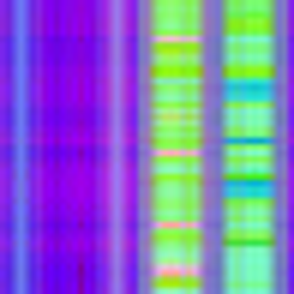

Reconstruct image


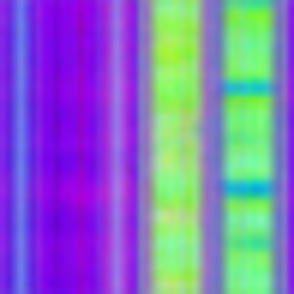

In [ ]:
#Reconstracted TSSIC images with VAE results
orig_img , _ = next(iter(test_loader)) 
print("Original image") 
displayTensor(orig_img[0])

print("Reconstruct image")
with torch.no_grad():
  VEA_model.eval()
  recon_img, mu, log_var = VEA_model(orig_img[0].expand(1,3,49,49).to(device))
  displayTensor(recon_img[0])

In [ ]:
def show(imgs):
  # your code goes here:
  Grid = make_grid(imgs, nrow=8, padding=5)
  img = torchvision.transforms.ToPILImage()(Grid)
  display(img)

It is possible to produce a 8 random movements that are similar to one of the six movements requested. 

In [ ]:
# creates random noise sample in the correct shape.
new_tssi_list = []

def generate_tssi(model, grid_size, latent):
    global new_tssi_list
    model.eval()
    dummy = torch.empty([batch_size,latent])
    z = torch.randn_like(dummy).to(device)

    #insert the random noise to the decoder to create new samples.
    sample = model.decode(z)

    j=0
    while j < grid_size: 
        new_tssi_list.append(sample[j])
        j+=1

    grid = make_grid(new_tssi_list)
    show(grid)

New 8 Movments

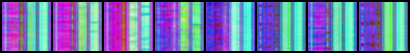

In [ ]:
generate_tssi(VEA_model,grid_size=8,latent=latent)

Leat display one new synthetic motions

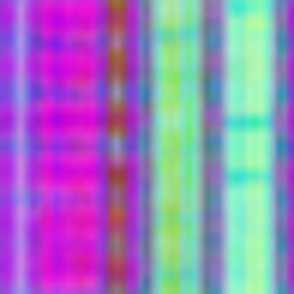

In [ ]:
## generate new sample
displayTensor(new_tssi_list[1])

In [ ]:
animateTSSI(new_tssi_list[1])

It is possible to produce a random movement that is similar to one of the six movements requested. In this method, however, we are unable to determine which of the six movements to produce.

## Analyzing the ability to generate similar synthetic movements by using a two-dimensional representation of t-SNE
 
 Our goal is to create synthetic motions similar to the six movements found in our TSSIC picture database, which contains 2004 photos labeled with one of the six movements. We used the TSSIC pictures to train a Variational Autoencoder (VAE) to recreate each movement. The VAE produces a latent vector for each TSSIC picture, yielding a probabilistic space of latent vectors.

We describe the probabilistic space as a cloud of points in an N-dimensional space as a spherical distribution, with a mean of 0 at the center and a standard deviation of 1 for the radius. This spherical distribution encompasses the six motions, and because the TSSIC pictures were successfully separated, we wish to represent the probabilistic space in a two-dimensional graph to demonstrate the apparent distinction between the movements. 

We used the dimensionality reduction approach t-SNE (t-Distributed Stochastic Neighbor Embedding) to visualize and explore high-dimensional data. t-SNE is very good for depicting complicated, non-linear interactions between data points.

The t-SNE algorithm maps high-dimensional data points to a lower-dimensional space (usually 2D or 3D) while keeping data point commonalities. The method does this by generating a probability distribution over the data points in the high-dimensional space and then mapping the points to the lower-dimensional space while preserving as many similarities as feasible.

In more detail, t-SNE starts by computing the pairwise similarities between all the data points in the high-dimensional space (In our case, we are using the latent space dimension). We are using those similarities to define a probability distribution over the data points, where the probability of a selected point is proportional to the similarity with its neighbors. The algorithm then maps the data points to the lower-dimensional space by optimizing a cost function that measures the difference between the high- and lower-dimensional space probabilities.

### TSNE Plot

In [ ]:
x, _ = VEA_model.encode(train_dataset[:][0].to(device))
y = torch.argmax(train_dataset[:][1], dim=1)
tsne_labels = [movmentsName[i] for i in y.tolist()]

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x.cpu().detach().numpy(), y)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1603 samples in 0.000s...
[t-SNE] Computed neighbors for 1603 samples in 0.079s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1603
[t-SNE] Computed conditional probabilities for sample 1603 / 1603
[t-SNE] Mean sigma: 1.621334
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.662430
[t-SNE] KL divergence after 300 iterations: 1.100349


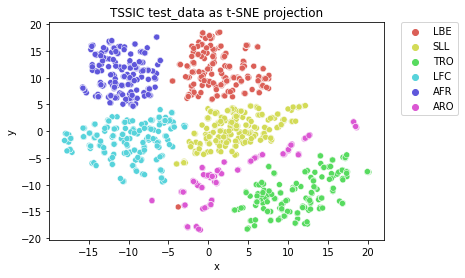

In [ ]:
df = pd.DataFrame()
df["lable"] = tsne_labels
df["x"] = tsne_results[:,0]
df["y"] = tsne_results[:,1]

sns.scatterplot(x="x", y="y", hue=df.lable.tolist(), palette=sns.color_palette("hls", 6), data=df).set(title="TSSIC test_data as t-SNE projection") 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

As demonstrated in the Figure above, the probability space of the latent vectors representing the characteristics of human movements, or TSSIC image properties, exhibits excellent separation. The separation is centered around the origin, resulting in a symmetrical distribution. This indicates that the VAE has generated a probability space that resembles a normal mixture distribution. Therefore, we can extract a vector from a normal distribution, pass it through the VAE, and obtain a novel movement.

###Synthesizes a new movement by combining two foreign movements TRO+SLL
After employing t-SNE to visualize the distributions of six exercise groups, we seek to showcase the effectiveness of using a Super Object, specifically TSSIC, to merge two distinct movements into a single, combined motion. Our demonstration involves merging the SLL and TRO movements, which we can characterize by leg and hand-to-chest movement, respectively.
Recall that the latent vectors representing the dominant characteristics of each object, in this case, a super object describing a movement, are crucial to our method. Each TSSIC image is transformed into a latent vector using VAE, with each vector serving as a point in an N-dimensional space, where in our example, N is 16. VAE converts the distribution of the latent vectors to a normal distribution, meaning that it maps each original latent vector to an equivalent point in a normal distribution.
We then choose a latent N-dimensional vector from the normal distribution space belonging to the SLL movement and one from the TRO movement. We create a vector origin between them (the average of the two vectors) and obtain a new synthetic vector V-merge in the normal distribution space. This vector represents the combined motion we aim to generate. We then inject this vector into the VAE decoder and use it to reconstruct a new movement - the joint movement - which combines the hand and leg movements of the SLL and TRO movements, respectively.
Using t-SNE, TSSIC, and VAE allows us to merge the distinct characteristics of two movements and generate a new, unique synthetic movement.

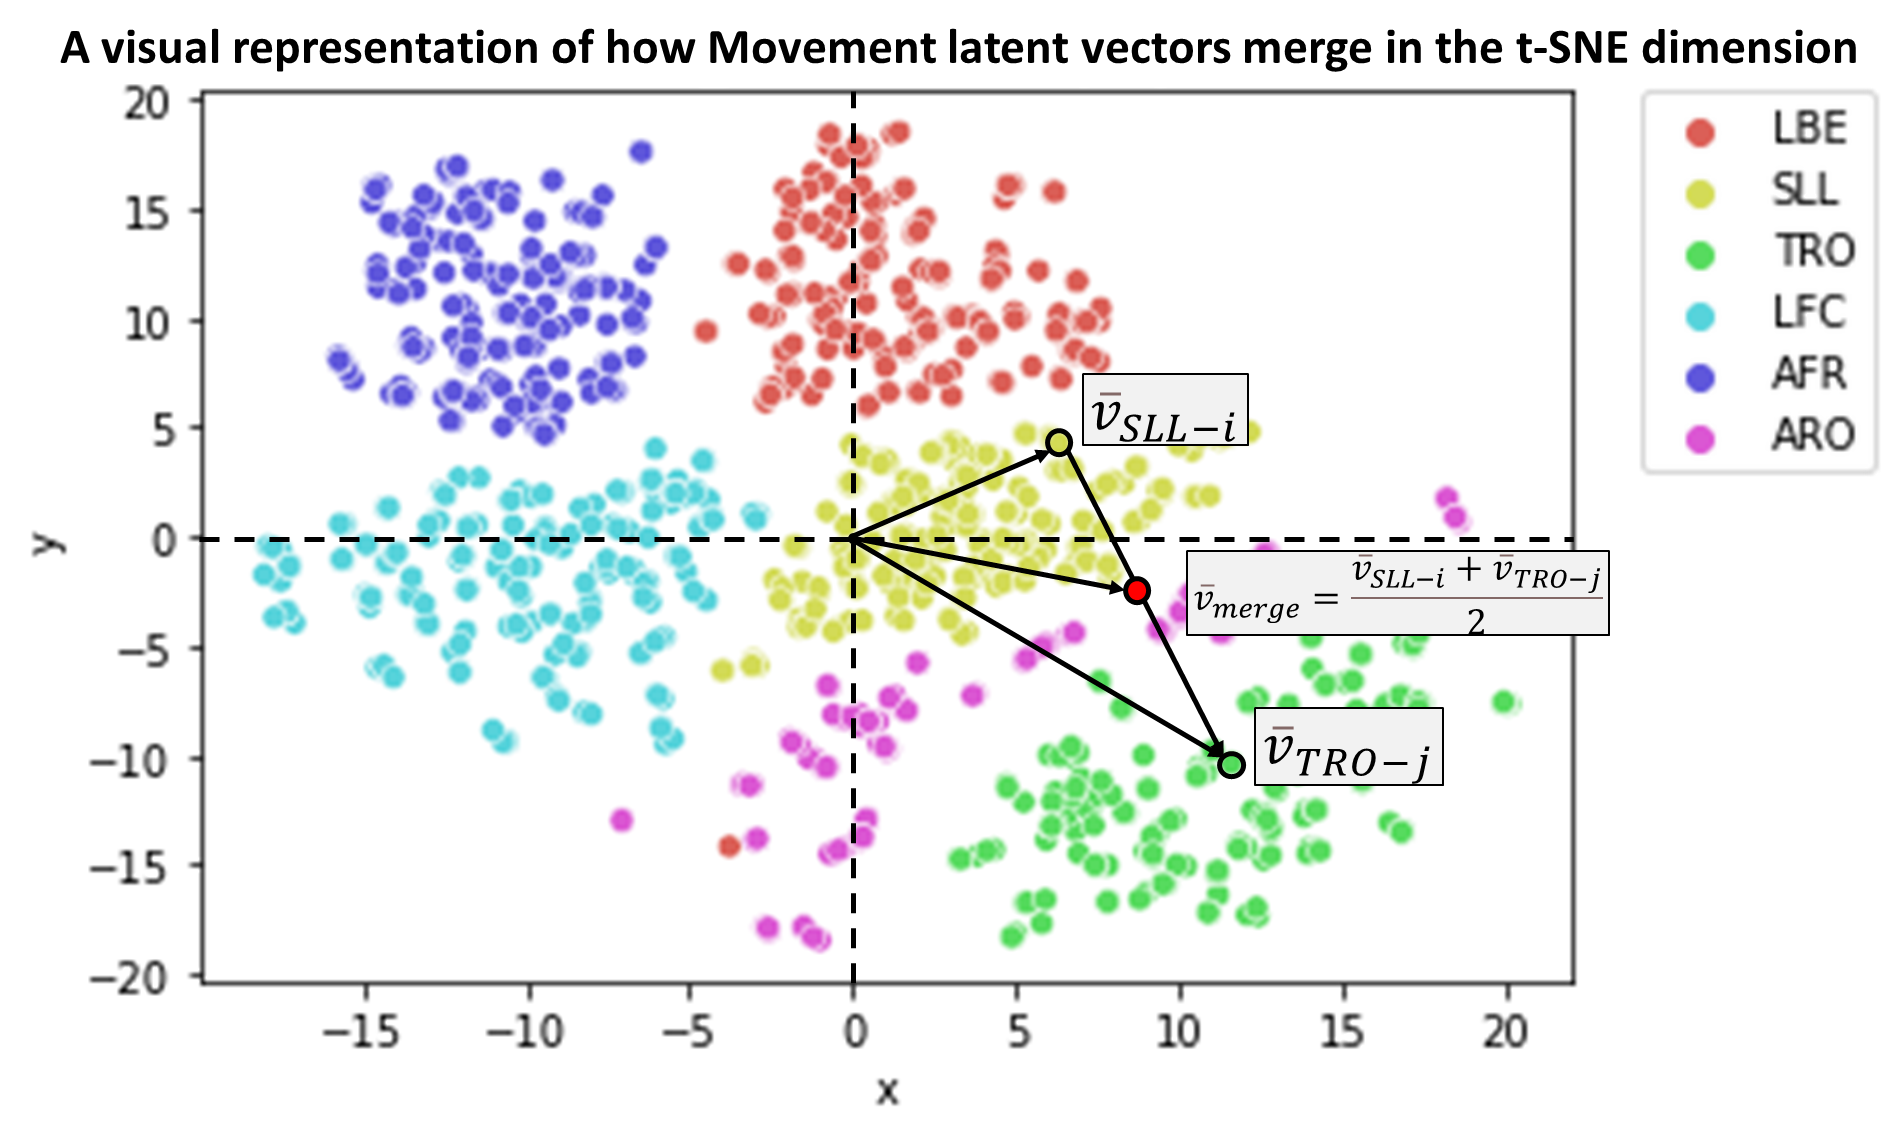

In [ ]:
#all_mu - the TSSIC latent rpresentation in the Nurmal Disterbution
#all_logvar - not in use in this cell. It is one od the AVE outputs
all_mu, all_logvar = VEA_model.encode(train_dataset[:][0].to(device))


We create a vector origin between them (the average of the two vectors) and obtain a new synthetic vector L in the normal distribution space. This vector represents the combined motion we aim to generate.

In [ ]:
new_mu = (all_mu[2]+all_mu[9])/2

We then inject this vector into the VAE decoder and use it to reconstruct a new movement - the joint movement - which combines the hand and leg movements of the SLL and TRO movements, respectively.

In [ ]:
new_output = VEA_model.decode(new_mu)

Display the combined TSSIC SLL+TRO

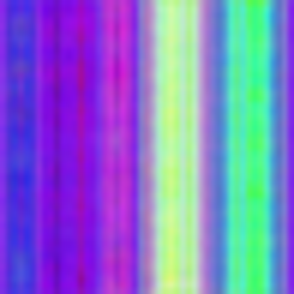

In [ ]:
displayTensor(new_output[0])

Animate the combined skeleton SLL+TRO

In [ ]:
animateTSSI(new_output[0])

Using t-SNE, TSSIC, and VAE allows us to merge the distinct characteristics of two movements and generate a new, unique synthetic movement.

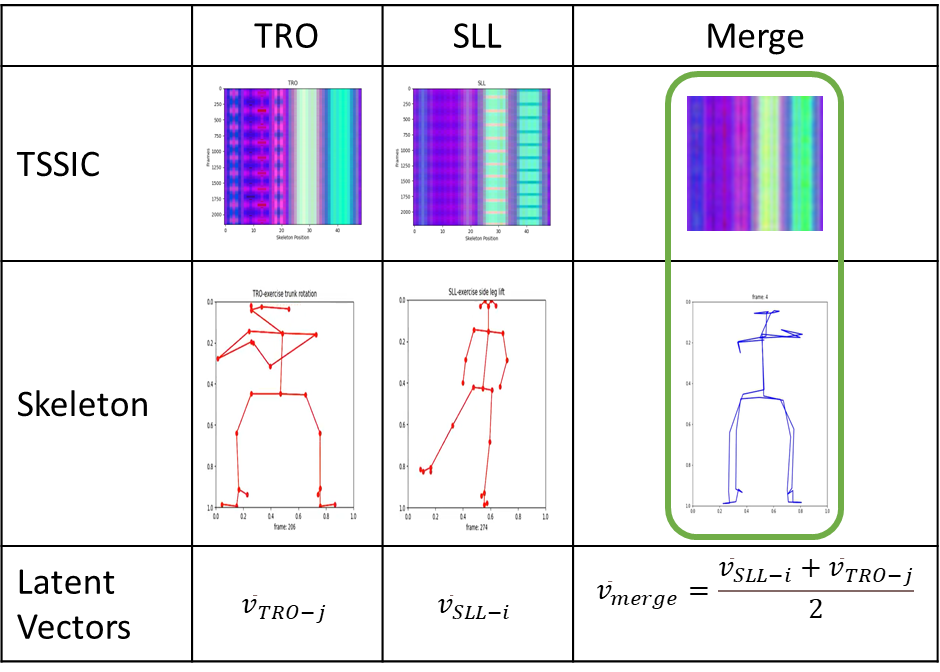

In [ ]:
print(movmentsName[torch.argmax(train_dataset[:][1][9]).tolist()], movmentsName[torch.argmax(train_dataset[:][1][2]).tolist()])

TRO SLL


## Generator of Synthetic Movements for Specific Types Using Super Object Method
Our previous demonstrations have showcased the power of the super object method in classifying, compressing, reproducing, and merging movements. We introduce a new capability: a generator that creates a specific type of movement from the six pre-defined movements.

The generator operates by converting the latent vector distribution to a normal distribution.

### Find the mean and variance of each Latent movement group
 Each subgroup of movements has a different mean and variance, and to produce a new movement of a specific type, we create a sub-distribution corresponding to the requested subgroup. 

#### AFR

In [ ]:
AFR_dataset = data.TensorDataset(x_data[:336], y_data[:336])
AFR_latent, _ = VEA_model.encode(AFR_dataset[:][0].to(device))
AFR_var, AFR_mean = torch.var_mean(AFR_latent, dim=0, unbiased=False)

#### ARO

In [ ]:
ARO_dataset = data.TensorDataset(x_data[336:672], y_data[336:672])
ARO_latent, _ = VEA_model.encode(ARO_dataset[:][0].to(device))
ARO_var, ARO_mean = torch.var_mean(ARO_latent, dim=0, unbiased=False)

#### LBE

In [ ]:
LBE_dataset = data.TensorDataset(x_data[672:996], y_data[672:996])
LBE_latent, _ = VEA_model.encode(LBE_dataset[:][0].to(device))
LBE_var, LBE_mean = torch.var_mean(LBE_latent, dim=0, unbiased=False)

#### LFC

In [ ]:
LFC_dataset = data.TensorDataset(x_data[996:1332], y_data[996:1332])
LFC_latent, _ = VEA_model.encode(LFC_dataset[:][0].to(device))
LFC_var, LFC_mean = torch.var_mean(LFC_latent, dim=0, unbiased=False)

#### SLL

In [ ]:
SLL_dataset = data.TensorDataset(x_data[1332:1668], y_data[1332:1668])
SLL_latent, _ = VEA_model.encode(SLL_dataset[:][0].to(device))
SLL_var, SLL_mean = torch.var_mean(SLL_latent, dim=0, unbiased=False)

#### TRO

In [ ]:
TRO_dataset = data.TensorDataset(x_data[1668:2004], y_data[1668:2004])
TRO_latent, _ = VEA_model.encode(TRO_dataset[:][0].to(device))
TRO_var, TRO_mean = torch.var_mean(TRO_latent, dim=0, unbiased=False)

### Create action from Noise
We then generate a series of latent vectors from each sub-distribution and pass them through the VAE Decoder to obtain a new TSSIC image depicting a sequence of skeletons in certain positions, which, when played in order, produce a new synthetic skeleton movement of the requested type.

#### AFR example

AFR mean vector:

In [ ]:
AFR_mean

tensor([-0.1222,  0.0243, -0.1282, -0.2463,  0.6442, -0.0230,  1.1109, -0.3722,
        -0.8885, -0.0817,  0.0304, -0.3515,  1.3365, -0.0357,  0.1033,  0.2776],
       device='cuda:0', grad_fn=<VarMeanBackward0>)

AFR variance vector:

In [ ]:
AFR_var

tensor([0.9046, 0.7495, 0.8113, 0.7204, 0.8015, 0.6158, 0.5590, 0.6356, 0.1773,
        0.8261, 0.7492, 0.7742, 0.9496, 0.6302, 0.7599, 0.2573],
       device='cuda:0', grad_fn=<VarMeanBackward0>)

Generate new vector based on mean and variance values:

In [ ]:
AFR_latent = torch.unsqueeze(torch.normal(AFR_mean, AFR_var), dim=0)
generated_AFR = VEA_model.decode(AFR_latent.to(device))

Display image:

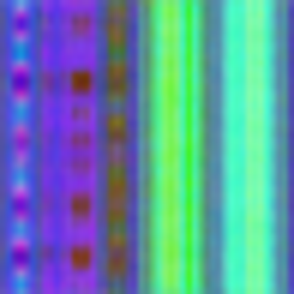

In [ ]:
displayTensor(generated_AFR[0])

Animate TSSI:

In [ ]:
animateTSSI(generated_AFR[0])

Lets comape

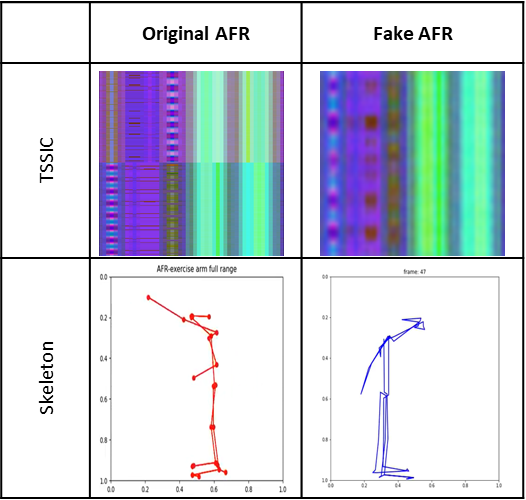

Figure 28 showcases our ability to generate a new AFR (Arm Full Rotate)  movement using the super object method. Notably, the TSSIC image features a dividing line in its center, which reflects the combined performance of the exercise, with the right arm working in the first half and the left arm in the second half. However, our reconstruction only includes the right-arm movement. Hence there is no line in the center.

As a reminder, we opted to play the synthetic movement in a mirror image of the original to distinguish between the two. The TSSIC image used to generate the synthetic movement describes a skeleton using 49 points, while the original skeleton uses 25 points. We preserved this format to demonstrate the refinement and authenticity of the synthetic reconstruction using VAE on the TSSIC image.
We previously demonstrated how to train the network to generate a skeleton of only 25 points by adding a constraint to the loss function. It provides further evidence of the authenticity of our synthetic movements and their potential applicability in real-world settings.

#### Now Lets generate 100 movement from each type (all 6 Movments)

In [ ]:
x_dataset = torch.empty([1,latent])
y_dataset = torch.empty([1,6])

for i in range(100):
  new_AFR = torch.unsqueeze(torch.normal(AFR_mean.cpu(), AFR_var.cpu()), dim=0)
  new_ARO = torch.unsqueeze(torch.normal(ARO_mean.cpu(), ARO_var.cpu()), dim=0)
  new_LBE = torch.unsqueeze(torch.normal(LBE_mean.cpu(), LBE_var.cpu()), dim=0)
  new_LFC = torch.unsqueeze(torch.normal(LFC_mean.cpu(), LFC_var.cpu()), dim=0)
  new_SLL = torch.unsqueeze(torch.normal(SLL_mean.cpu(), SLL_var.cpu()), dim=0)
  new_TRO = torch.unsqueeze(torch.normal(TRO_mean.cpu(), TRO_var.cpu()), dim=0)

  x = torch.cat((new_AFR, new_ARO, new_LBE, new_LFC, new_SLL, new_TRO))
  y = nnF.one_hot(torch.arange(0, 6))

  x_dataset = torch.cat((x_dataset,x))
  y_dataset = torch.cat((y_dataset,y))

Generate Latents vectors for all 6 movements

In [ ]:
generated_output = VEA_model.decode(x_dataset[1:].to(device))

Generate fake new TSSIC for all 6 movements

In [ ]:
generated_tssi = data.TensorDataset(generated_output.cpu(), y_dataset[1:].cpu())

### Analyzing the quality of the generate 6 movements using a confusion matrix

In [ ]:
x = generated_tssi[:][0]
y = generated_tssi[:][1]
EfficientNet_model.to(device)
output = EfficientNet_model(x.to(device))
y_pred = torch.sigmoid(output)
y_pred = (y_pred > 0.5).float()

#### Confusion Matrix

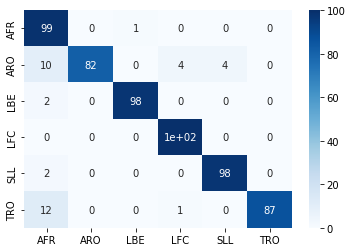

In [ ]:
y_true = np.argmax(y.cpu(), axis=1)
y_pred = np.argmax(y_pred.cpu(), axis=1)

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, xticklabels = movmentsName, yticklabels = movmentsName)

We pass the synthetic movements through an EfficientNet-B7 CNN network-based movement classifier to validate the generator's effectiveness and present a confusion ma-trix (see Figure 29). The matrix's diagonal clearly illustrates the classifier's near-perfect success in classifying all the new fake movements.
Overall, this new capability of the super object method allows us to enrich our da-taset with more tagged movements of the same type, which is an advanced form of aug-mentation. Additionally, we can use the movement merging algorithm to create a new set of movements different from the original six.


# Utilizing a Twin Siamese Neural Network to score the quality of physical therapy exercises performed by patients relative to expert physical therapists

In this section, we highlight the effectiveness of the Super Object via the TSSIC method in providing a score for the quality of exercise performance compared to an ex-pert physiotherapist. Given that our research framework focuses on demonstrating the effectiveness of the Super Object method, our dataset consists solely of examples from healthy individuals and does not include patients with limitations. 
To validate the effectiveness of our method, we rely on a set of exercises performed by an expert physiotherapist as a reference point. We developed a Siamese twin network based on the EfficientNet network to provide a score for exercise performance. This net-work features two channels: a reference channel that receives the specialist's TSSIC and an identical parallel channel that receives the TSSICs of all students performing a mix of exercises. Each channel produces a latent vector, and we measure the Euclidean distance between the vectors of the expert and the student performing a particular exercise. The smaller the distance between the vectors, the higher the score, with a score of 100 indicat-ing that the student's movement performed well, according to the expert (in our case, performing a similar movement). Conversely, the greater the distance, the lower the score, aiming toward 0. 


### Data

In [ ]:
filePath = '/content' #^^^^

# x data
fileName = filePath+'/'+'expert_tssi_x_data.npy'
expert_x_data  = np.load(fileName, allow_pickle=True)
expert_x_data = expert_x_data.transpose(0, 3, 1, 2)

# y data
fileName = filePath+'/'+'expert_tssi_y_data.npy'
expert_y_data = np.load(fileName,allow_pickle=True)
expert_y_data = np.array([x.numpy() for x in expert_y_data.tolist()]) #^^^^

### Model -  Siamese Network Layout

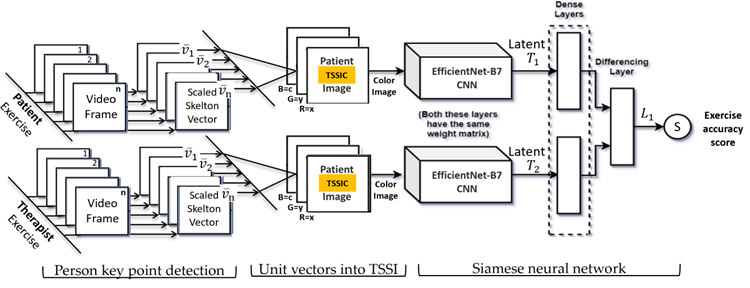

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = EfficientNet_model

    def forward_once(self, x):
        x = self.cnn.extract_features(x)
        x = x.view(x.size()[0], -1)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        euclidean_distance = nnF.pairwise_distance(output1, output2)
        return euclidean_distance

In [ ]:
#summary(SiameseNetwork(),((1,3,49,49),(1,3,49,49)))

### Parameters

In [ ]:
batch_size = 32
alpha = 30
siameseNet_test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False) 
SiameseNetwork_model = SiameseNetwork().to(device)
SiameseNetwork_model.eval()
final_matrix = np.empty([6, 6])

### Inference and Accurcy scoring

$f = a \frac{100}{D}$<br>
Where:

D - Uclidean distance between the reference expert and the student Latent<br>
$\alpha$ - Scaling factor, we empirically chose alpha as 30<br>

Finally we obtain a score between 0 and 100 by the following formula:<br>
$s = \begin{cases} f & \text{if } f<100   \text{, else }  \text{ }  100 & \text{       if } f\geq 100 \} \end{cases}$<br>

s -score 




In [ ]:
for i, movementName in enumerate(movmentsName):
  print(f"Running dataset with Movment {movementName} as reference...")
  y_pred = []
  movments = []
  with torch.no_grad():
      for x2, y in siameseNet_test_loader:
          y = np.argmax(y, axis=1)
          x1 = np.repeat(np.expand_dims(expert_x_data[i], axis=0), len(x2), axis=0)
          x1 = torch.from_numpy(x1).float()
          y_pred_batch = SiameseNetwork_model(x1.to(device), x2.to(device))
          y_pred.extend(y_pred_batch.cpu())
          movments.extend(y.tolist())

  npy_y_pred = np.array(y_pred)
  npy_movments = np.array(movments)

  for j in range(6):
    avg = np.mean(npy_y_pred[npy_movments==j])
    var = np.var(npy_y_pred[npy_movments==j])
    final_matrix[i][j] = alpha*(100/avg)

final_matrix = np.clip(final_matrix, 0, 100)

Running dataset with Movment AFR as reference...
Running dataset with Movment ARO as reference...
Running dataset with Movment LBE as reference...
Running dataset with Movment LFC as reference...
Running dataset with Movment SLL as reference...
Running dataset with Movment TRO as reference...


### Covariance Matrix

The Euclidean distance method, commonly used for measuring the similarity be-tween two vectors, suffers from the challenge of an unlimited upper limit to the maxi-mum distance, making it difficult to define a final scale between 0 and 100. To address this limitation, we developed an empirical method for scoring to demonstrate the effec-tiveness of using the Super Object method rather than focusing on providing an accurate score. Our empirical method involves using the inverse of the Euclidean distance and setting a threshold for the maximum value beyond which any similarity score would be considered 100. Specifically, we define a threshold distance of 100, such that any inverse Euclidean distance between the reference and student vectors greater than or equal to 100 is capped at a score of 100. Conversely, any distance less than 100 is multiplied by a scaling factor alpha (in our case, we empirically chose alpha as 30) to obtain a score be-tween 0 and 100. Using this method, we can provide a qualitative score that effectively demonstrates the advantages of the Super Object method while accommodating the chal-lenges posed by the Euclidean distance method's unlimited upper limit.

In [ ]:
def displayMatrix(matrix):
  fig, ax = plt.subplots(figsize=(16,8))
  ax.set_title("Covariance Matrix")
  cax = ax.matshow(matrix, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  for i in range(matrix.shape[0]):
      for j in range(matrix.shape[1]):
          c = matrix[j,i]
          ax.text(i, j, str(c), va='center', ha='center', fontsize=16, color='red', fontstyle='italic')
  
  ax.set_xticklabels(['']+movmentsName)
  ax.set_yticklabels(['']+movmentsName)
  

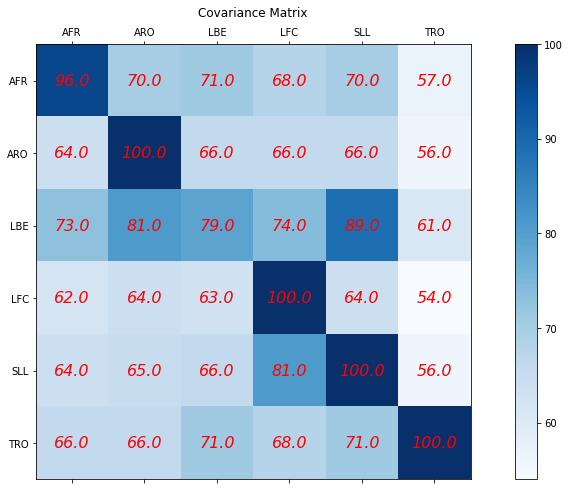

In [ ]:
final_matrix = np.round(final_matrix)
displayMatrix(final_matrix)

To validate the effectiveness of our method, we consider an incorrect movement as one that differs from the reference movement performed by the expert physiotherapist. Specifically, we compare the performance of each student's movement to the reference movement of the AFR exercise and expect to obtain a high score for those who accurately perform the AFR exercise and a low score for those who perform a different exercise in relation to the expert. To achieve this, we repeat this process six times, using each of the six reference movements performed by the expert as the reference channel. We compare each student's movement to the corresponding reference movement and calculate the score using our empirical method for scoring. We summarize the scoring results in a con-fusion matrix, which provides an overview of the accuracy of each type of exercise the students perform (see Figure above). The matrix rows represent the reference exercise per-formed by the expert physiotherapist, while the columns represent the type of exercise performed by the students. In each cell, we present the average score obtained for each type of exercise, enabling us to evaluate the effectiveness of our method in accurately classifying different types of movements. 

The effectiveness of our method is evident from the confusion matrix, which shows that the average score is high for most exercises, except for the LBE exercise. Interesting-ly, the LBE and the SLL exercise, for which the average score was also lower, share a common characteristic: the dominant movement is related to leg motion. In the LBE exer-cise, the leg motion is backward, while in the SLL exercise, it is sideways, which explains the system's confusion during the scoring process. To address this limitation, we can con-tinue the training process or explore alternative methods, such as using the EfficientNet network as a whole classifier to output a vector of probabilities for each student exercise. We can use this vector of probabilities as a score for the movement or calculate the Eu-clidean distance between the expert's and student's probability vectors. However, since our study aims to demonstrate the effectiveness of the Super Object method for human movement classification, we believe that our empirical scoring method is sufficient to prove the effectiveness of our approach.


#### Compared Experts with Sytetic Generated data  

We repeat the scoring process to complete our evaluation using the synthetic exercises we created with VAE. It enables us to demonstrate the quality of the synthetic movements and the effectiveness of our scoring method based on Siamese twin networks.
Siamese twin networks have proven efficient for measuring the similarity between images and objects in various contexts. We aim to illustrate that any existing algorithm designed for analyzing the content of an image, particularly object recognition, can be used for analyzing movements based on the Super Object method. It shows the versatility and applicability of our approach beyond the scope of movement classification.

In [ ]:
GeneratedTSSI_test_loader = torch.utils.data.DataLoader(generated_tssi, batch_size=batch_size, shuffle=False) 
gen_final_matrix = np.empty([6, 6])
alpha = 25

for i, movementName in enumerate(movmentsName):
  print(f"Running generated tssi dataset with Movment {movementName} as reference...")
  y_pred = []
  movments = []
  with torch.no_grad():
      for x2, y in GeneratedTSSI_test_loader:
          y = np.argmax(y, axis=1)
          x1 = np.repeat(np.expand_dims(expert_x_data[i], axis=0), len(x2), axis=0)
          x1 = torch.from_numpy(x1).float()
          y_pred_batch = SiameseNetwork_model(x1.to(device), x2.to(device))
          y_pred.extend(y_pred_batch.cpu())
          movments.extend(y.tolist())

  npy_y_pred = np.array(y_pred)
  npy_movments = np.array(movments)

  for j in range(6):
    avg = np.mean(npy_y_pred[npy_movments==j])
    var = np.var(npy_y_pred[npy_movments==j])
    gen_final_matrix[i][j] = alpha*(100/avg)

gen_final_matrix = np.clip(gen_final_matrix, 0, 100)

Running generated tssi dataset with Movment AFR as reference...
Running generated tssi dataset with Movment ARO as reference...
Running generated tssi dataset with Movment LBE as reference...
Running generated tssi dataset with Movment LFC as reference...
Running generated tssi dataset with Movment SLL as reference...
Running generated tssi dataset with Movment TRO as reference...


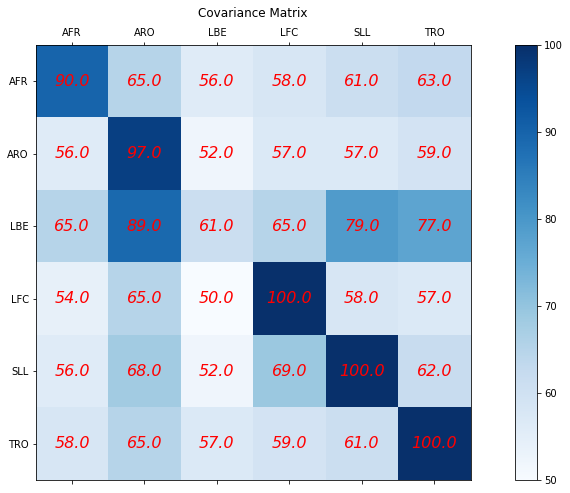

In [ ]:
gen_final_matrix = np.round(gen_final_matrix)
displayMatrix(gen_final_matrix)

The effectiveness of our method is evident from the confusion matrix presented in figure 31, which shows that the average score is high for most exercises, in the diagonal as expected.

# Conclusion
In this work, we presented a novel and versatile approach to reference human movements, based on the use of a super object described in the form of a TSSIC image. Our solution provides a generic method for analyzing and processing human move-ments, using standard deep learning network architectures, allowing for a variety of tasks such as classification, measurement, prediction, completion, and improvement of movements.

To illustrate the effectiveness of our method, we used OpenPose and MediaPipe software to extract a graph of a human skeleton from a video and consolidated them into a TSSIC image. We focused on measuring physiotherapy treatments using a dataset of approximately 100 students who performed six physical therapy exercises prescribed by an expert physiotherapist. The data set was divided into three types: exercises performed by an expert, exercises performed in a controlled environment and under laboratory conditions, and a third group who performed the exercises freestyle at home.

We demonstrated the versatility of our approach by injecting identical TSSIC images into three different networks (EfficientNet, Variational Autoencoder, and Twin Siamese networks) for different tasks. We successfully classified human movements performed under laboratory conditions and with high accuracy for movements performed under uncontrolled, noisy conditions, except for cases where there were not enough examples for training.

Furthermore, we demonstrated the use of the VAE architecture to generate new syn-thetic skeletons and even merged different movements to create a unique synthetic movement. We explained the VAE architecture using the TSNE algorithm to present the N-dimensional distribution space of the latent vectors in a two-dimensional way.

Finally, we presented the use of the TSSIC method in measuring the performance of physical therapy exercises in relation to a specialist physiotherapist using a Siamese twin network. We proposed an empirical scoring method for the quality of the exercise per-formance and summarized the results in two confusion matrices. Our experiments demonstrated the effectiveness of our super object method in reference to human move-ment analysis.


#References
1.	Y. Segal et al., ‘Camera Setup and OpenPose software without GPU for calibration and recording in telerehabilitation’, in IEEE E-Health and Bioengineering, Lasi, Romania, 2021.
2.	P. Kutilek et al., ‘Camera System for Efficient non-contact Measurement in Distance Medicine’, Prague, 2020, pp. 1–6.
3.	J. Adolf, J. Dolezal, M. Macas, and L. Lhotska, ‘Remote Physical Therapy: Requirements for a Single RGB Camera Motion Sensing’, in 2021 International Conference on Applied Electronics (AE), Sep. 2021, pp. 1–4. doi: 10.23919/AE51540.2021.9542912.
4.	N. Carissimi, P. Rota, C. Beyan, and V. Murino, ‘Filling the Gaps: Predicting Missing Joints of Human Poses Using Denoising Autoencoders’, in Computer Vision – ECCV 2018 Workshops, vol. 11130, L. Leal-Taixé and S. Roth, Eds. Cham: Springer International Publishing, 2019, pp. 364–379. doi: 10.1007/978-3-030-11012-3_29.
5.	G. Koch, ‘Siamese Neural Networks for One-Shot Image Recognition’, Graduate Department of Computer Science, Toronto, 2015. Online.. Available: http://www.cs.toronto.edu/~gkoch/files/msc-thesis.pdf
7.	Z. Cao, G. Hidalgo, T. Simon, S.-E. Wei, and Y. Sheikh, ‘OpenPose: Realtime Multi-Person 2D Pose’, IEEE Conf. Comput. Vis. Pattern Recognit. CVPR, pp. 7291–7299, 2017.
8.	C. Lugaresi et al., ‘MediaPipe: A Framework for Perceiving and Processing Reality’, 2019. Online.. Available: https://mixedreality.cs.cornell.edu/s/NewTitle_May1_MediaPipe_CVPR_CV4ARVR_Workshop_2019.pdf
9.	J. Adolf, J. Dolezal, P. Kutilek, J. Hejda, and L. Lhotska, ‘Single Camera-Based Remote Physical Therapy: Verification on a Large Video Dataset’, Appl. Sci., vol. 12, no. 2, Art. no. 2, Jan. 2022, doi: 10.3390/app12020799.
10.	Y. Liao, A. Vakanski, and M. Xian, ‘A Deep Learning Framework for Assessing Physical Rehabilitation Exercises’, IEEE Trans. Neural Syst. Rehabil. Eng., vol. 28, no. 2, pp. 468–477, Feb. 2020.
11.	J. Brownlee, Generative Adversarial Networks with Python: Deep Learning Generative Models for Image Synthesis and Image Translation. Machine Learning Mastery, 2019.
12.	W. Xi, G. Devineau, F. Moutarde, and J. Yang, ‘Generative Model for Skeletal Human Movements Based on Conditional DC-GAN Applied to Pseudo-Images’, Algorithms, vol. 13, no. 12, 2020, doi: doi: 10.3390/a13120319.
13.	Z. Yang, Y. Li, J. Yang, and J. Luo, ‘Action Recognition With Spatio–Temporal Visual Attention on Skeleton Image Sequences’, IEEE Trans Circuits Syst Video Technol, vol. 29, no. 8, pp. 2405–2415, 2019.
14.	C. Caetano, J. Sena, F. Brémond, J. A. dos Santos, and W. R. Schwartz, ‘SkeleMotion: A New Representation of Skeleton Joint Sequences Based on Motion Information for 3D Action Recognition’, ArXiv190713025 Cs Eess. Oct. 2019. Online.. Available: http://arxiv.org/abs/1907.13025
15.	B. Ren, M. Liu, R. Ding, and H. Liu, ‘A Survey on 3D Skeleton-Based Action Recognition Using Learning Method’. Feb. 2020. Online.. Available: http://arxiv.org/abs/2002.05907
16.	L. Ma, X. Jia, Q. Sun, B. Schiele, T. Tuytelaars, and L. V. Gool, ‘Pose Guided Person Image Generation’. Jan. 2018. Online.. Available: http://arxiv.org/abs/1705.09368
17.	C. Caetano, F. Brémond, and W. R. Schwartz, ‘Skeleton Image Representation for 3D Action Recognition based on Tree Structure and Reference Joints’. Sep. 2019. Online.. Available: http://arxiv.org/abs/1909.05704
18.	J. L. Barron, D. J. Fleet, S. S. Beauchemin, and T. A. Burkitt, ‘Performance of Optical Flow Techniques’.
19.	D. Osokin, ‘Real-time 2D Multi-Person Pose Estimation on CPU: Lightweight OpenPose’. arXiv, Nov. 29, 2018. doi: 10.48550/arXiv.1811.12004.
23.	J. Brownlee, ‘How to Normalize and Standardize Time Series Data in Python’, MachineLearningMastery.com, Dec. 11, 2016. https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ (accessed Jan. 21, 2023).
24.	‘Normalization’, Codecademy. https://www.codecademy.com/article/normalization (accessed Jan. 21, 2023).
25.	‘How to normalize the RMSE’. https://www.marinedatascience.co/blog/2019/01/07/normalizing-the-rmse// (accessed Jan. 21, 2023).
26.	E. Boudreau, ‘Unit-Length Scaling: The Ultimate In Continuous Feature-Scaling?’, Medium, Jul. 27, 2020. https://towardsdatascience.com/unit-length-scaling-the-ultimate-in-continuous-feature-scaling-c5db0b0dab57 (accessed Jan. 21, 2023).

